# Particle Model to explain the observed Gamma-ray emission

This notebook show the code which was used to compute the physcial model presented in the publication https://arxiv.org/abs/2403.16802.

Using the GAMERA package, a electron population is computed with which the observed gamma-ray emission can be described.

Since a x-ray pulsar wind nebula, es well as a TeV pulsar wind nebula and extended emission were observed, all which are expected to show emission from electrons at different ages, 3 electron generations are introduced

Then a Markow-Chain-Monte-Carlo optimization is employed to identifiy the confidence intervals of the model parameters best describing the observed emission.

At last, a diffusion coefficient is computed from the extension of the gamma-ray emission. 

In [ ]:
import numpy as np
import sys, os
#sys.path.append('/home/user/Documents/GAMERA/lib')
sys.path.append('/lfs/l7/hess/users/twach/modeling/GAMERA/lib')
import gappa as gp
import utilities as util
from scipy.stats import norm
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
import scipy.constants as cs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from uncertainties import unumpy

import scipy as sp
from scipy.interpolate import splev, splrep
from scipy import interpolate
import matplotlib.colors as colors
import astropy.units as u
import astropy.constants as c

In [2]:
plotDir = '/lfs/l7/hess/users/twach/modeling/Modeling'
# save the figure in the plotDir under a name I give and in a format I decide upon
def save(fig, filename):#, left=0.15, bottom=0.15, top=0.95, right=0.95):
    savedir = '{}'.format(plotDir)
    #fig.subplots_adjust(left=left, bottom=bottom, top=top, right=right)
    for form in ['png', 'pdf']:
        fig.savefig('{}/{}.{}'.format(plotDir, filename, form),dpi=150, bbox_inches = "tight")

In [34]:
from importlib import reload
reload(util)

<module 'utilities' from '/lfs/l7/hess/users/twach/modeling/Modeling/utilities.py'>

In [4]:
fu = gp.Utils()
bins = 200
eV_to_TeV = 1e-12

#### position of the system

In [5]:
location_pwn = {
    ##PSR J1813-1749 from ATNF
    'distance': 6.2e3, #pc
    'longi': 12.81618474, #deg 
    'lati' : -0.01919045,  #deg in GCS
}

In [6]:
location_snr = {
    #location of the system SNR G11.0-0.2
    #(put at the same location as of pulsar above, most likely associated)
    'distance': 6.2e3, #pc 
    'longi': 12.81618474, #deg 
    'lati' : -0.01919045,  #deg in GCS
}

#### known properties

In [7]:
#taken from ATNF
known_properties = {
    #pulsar properties
    'e_dot' : 5.6e37, #erg/sec
    'char_age' :5585, # yrs     (taken form this paper: https://arxiv.org/pdf/2110.09727.pdf)                                                                                                                             
    'P' :  44.74055970e-3,  #sec                                                                                                                              
    'P_dot' :  1.26999e-13 #/sec/sec  
}

#### Model parameters

In [8]:
def define_model_parameters_scales(model_parameters):
    for key in model_parameters.keys():
        scale = 100./(model_parameters[key][-1] - model_parameters[key][1])
        model_parameters[key].append(scale) #apply scaling and add to dict

In [9]:
pwn_labels = ["Theta (fraction)", "B(Now)(G)", "P0 (s)", "log10(Ecut/TeV)", "spectral index (wind)", "Time fraction (X-ray)", "Time fraction (PWN)"]
pwn_fit_parameters = ['theta','b_now','P0','ecut','alpha', 'time_frac_xray', 'time_frac_pwn']
def rescale_model_parameters(name, labels, fit_parameters, model_parameters, curvefit_result): # opt_pars,
    rescaled_params = []
    for i,par in enumerate(fit_parameters):
        curveFit = curvefit_result[i]/model_parameters[par][-1]
        rescaled_params.append(curveFit)
    return rescaled_params

In [10]:
snr_labels = ["alpha_p", "log10(power_p/erg)", "del_alpha", "log10(k_ep)", "b_now_snr (G)"]
snr_fit_parameters = ['alpha_p','power_p','del_alpha','k_ep','b_now_snr', 'density_mc']
def rescale_model_parameters_snr(name, labels, fit_parameters, model_parameters, curvefit_result): # opt_pars,
    rescaled_params = []
    for i,par in enumerate(fit_parameters):
        curveFit = curvefit_result[i]/model_parameters[par][-1]
        rescaled_params.append(curveFit)
    return rescaled_params

In [11]:
model_parameters_snr = {   
    'density_mc' : [40,10,100], #/cm3 #high particle density region
    'alpha_p' : [2.4,1.9,2.9],
    'power_p' : [49,47,51], #log10(E/erg)
    'del_alpha' : [0.0,-1.0,1.0],
    'k_ep' : [-4,-7,-1], #ratio of electron spectrum norm to proton log10(Kep)
    'b_now_snr' : [100e-6,3e-6,300e-6], #Gauss
}
define_model_parameters_scales(model_parameters_snr)

### Observations

In [12]:
#radio data
df_radio = pd.read_csv("radio_data.txt", comment="#", delimiter='\t')
df_radio = util.calculate_sed_radio(df_radio)

In [13]:
df_suzaku = pd.read_csv("x_ray_data.txt", comment="#", delimiter='\t')
df_suzaku['e_ref'] = df_suzaku['Energy [eV]']*eV_to_TeV 
df_suzaku['sed'] = df_suzaku['energy flux [erg/cm2s]']
df_suzaku['errp [erg/cm2s]'][5:] = df_suzaku['errp [erg/cm2s]'][5:] - df_suzaku['energy flux [erg/cm2s]'][5:]
df_suzaku['errn [erg/cm2s]'][5:] = df_suzaku['energy flux [erg/cm2s]'][5:] - df_suzaku['errn [erg/cm2s]'][5:] 

df_suzaku['errp [erg/cm2s]'][0:5] = df_suzaku['energy flux [erg/cm2s]'][0:5]*0.05
df_suzaku['errn [erg/cm2s]'][0:5] = df_suzaku['energy flux [erg/cm2s]'][0:5] *0.05


df_suzaku['sed_err'] = ((df_suzaku['errp [erg/cm2s]']+df_suzaku['errn [erg/cm2s]'])/2)+0.3*10**-12

In [14]:
import astropy
#fermi data
fermi_data_B = astropy.table.Table.read('fluxpoints_B_fermi.fits.gz')
df_fermi_B_ul, df_fermi_B = util.calculate_sed_fermi(fermi_data_B)
fermi_data_C = astropy.table.Table.read('fluxpoints_C_fermi.fits.gz')
df_fermi_C_ul, df_fermi_C = util.calculate_sed_fermi(fermi_data_C)
fermi_data_A = astropy.table.Table.read('fluxpoints_A_fermi.fits.gz')
df_fermi_A_ul, df_fermi_A = util.calculate_sed_fermi(fermi_data_A)

In [15]:
#hess
df_hess_relic_full = astropy.table.Table.read('fluxpoints_B_hess.fits.gz')
util.calculate_sed_hess(df_hess_relic_full)
df_hess_relic = df_hess_relic_full

df_hess_pwn = astropy.table.Table.read('fluxpoints_A_hess.fits.gz')
util.calculate_sed_hess(df_hess_pwn)

counts,e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,ts,sqrt_ts,norm_errp,norm_errn,norm_ul,norm_scan,stat_scan,dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn,is_ul,sed,sed_err,sed_errp,sed_errn
,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int64[1],float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64[11],float64[11],float64,float64,float64,float64,float64,bool,float64,float64,float64,float64
0,0.17782794173115227,0.1000000014901161,0.3162277638912201,9.043212851272244e-11,1.9097648999789383e-11,3.2747441948673845e-12,2.859715020963239e-12,--,--,False,--,--,--,--,--,--,-- .. --,-- .. --,--,--,--,--,--,False,--,--,--,--
47509,0.5623413233003779,0.3162277638912201,1.0,1.0079969578963093e-11,6.826828395795246e-12,3.644748799805237e-12,3.187566240047023e-12,0.998539830223308,156676.18412533897,True,0.07120819737288844,366.7766832616471,19.151414654318547,0.07220107424543788,0.07021806268262765,1.1450458141302948,0.20000000000000004 .. 5.000000000000001,156871.19856807412 .. 157991.35584558157,1.0065251112033916e-11,1.1542026972952401e-11,7.177764632915152e-13,7.277846319624696e-13,7.077959357346103e-13,False,5.099024787163688e-12,3.6362331522859976e-13,3.68693422229338e-13,3.585672111299367e-13
19290,1.7782794208213866,1.0,3.162277698516846,9.521710742587242e-13,2.0725460602333165e-12,3.4455830826255354e-12,3.0110293533011914e-12,0.9925383236841299,103851.5163256099,True,0.07008701058551078,461.3800655501982,21.479759438834463,0.07127692683401256,0.0689063760915738,1.1374897124777665,0.20000000000000004 .. 5.000000000000001,104073.91206892954 .. 105077.88953928929,9.450662819052712e-13,1.0830848014882023e-12,6.673482416078838e-14,6.786782799340222e-14,6.561065814638949e-14,False,4.787676367076617e-12,3.380765419452831e-13,3.438163040943217e-13,3.323815519082269e-13
3314,5.623413286000636,3.162277698516846,10.000000000000002,7.622370655461253e-14,5.343405314033284e-13,2.766698496899859e-12,2.410405273359436e-12,1.2495300260488875,28772.00117396584,True,0.13238967238513402,274.9777139823782,16.582451989448913,0.13631195154166298,0.12851894594585245,1.5300936167438883,0.20000000000000004 .. 5.000000000000001,28905.672961413606 .. 29096.696768648162,9.524381003672775e-14,1.166294068437719e-13,1.0091231538745745e-14,1.0390202194198282e-14,9.796190422484766e-15,False,4.825021769942726e-12,5.112186486576391e-13,5.263644090023404e-13,4.962719575452355e-13
618,17.782793940068625,10.000000000000002,31.622776031494134,5.17111823255272e-15,1.1698813928187207e-13,1.8869551661212076e-12,1.6352511370039049e-12,0.6853447395405965,7478.570446595023,True,0.19630404530052215,36.240850020521975,6.0200373770037325,0.2122813998172987,0.1808980066758318,1.1426503210699173,0.20000000000000004 .. 5.000000000000001,7489.314035413849 .. 7600.527272541819,3.5439986782224734e-15,5.9087799087168686e-15,1.0151114277773852e-15,1.097732217027047e-15,9.354449805538375e-16,False,1.7953786448465955e-12,5.142522740683843e-13,5.561077074664612e-13,4.738935010996272e-13
83,56.23413201205665,31.622776031494134,100.00000000000004,2.9730222923496606e-16,2.1749767101421407e-14,1.0930896693498576e-12,9.401521808761261e-13,-165.69273005326977,1131.9411170655449,True,138.56638262216632,204.15135147045999,-14.28815423595574,88.25223217477658,99.55759967698081,-53.87681182299363,0.20000000000000004 .. 5.000000000000001,1335.027877287328 .. 1361.1724211859425,-4.926081801286456e-14,-1.601769625904878e-14,4.1196094450595304e-14,2.6237585360522872e-14,2.959869632124873e-14,False,-2.4955376318687113e-10,2.0869812588298936e-10,1.3291878673117648e-10,1.4994606972348753e-10


In [16]:
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, PowerLawSpectralModel
def plot_spectrum2(model, energy_range, color, label='xx'):
    if label !="xx":
        model.plot(energy_bounds=energy_range, energy_power=2, color=color, label=label)
    else:
        model.plot(energy_bounds=energy_range, energy_power=2, color=color)

    model.plot_error(energy_bounds=energy_range, energy_power=2, color=color)

In [17]:
spectral_model_hawc = PowerLawSpectralModel(
    index=2.54,
    amplitude=74e-15 *1.60* u.Unit("cm-2 s-1 TeV-1"),
    reference=7 * u.TeV)
spectral_model_hawc.parameters['index'].error = 0.04
spectral_model_hawc.parameters['amplitude'].error = 4.0e-15

spectral_model_km2a1 = PowerLawSpectralModel(
    index=3.74,
    amplitude=11.9e-16 *1.60* u.Unit("cm-2 s-1 TeV-1"),
    reference=50 * u.TeV)
spectral_model_km2a1.parameters['index'].error = 0.2
spectral_model_km2a1.parameters['amplitude'].error = 1.30e-16

spectral_model_km2a2 = PowerLawSpectralModel(
    index=3.49,
    amplitude=4.20e-16 *1.60* u.Unit("cm-2 s-1 TeV-1"),
    reference=50 * u.TeV)
spectral_model_km2a2.parameters['index'].error = 0.31
spectral_model_km2a2.parameters['amplitude'].error = 0.57e-16

spectral_model_wcda = PowerLawSpectralModel(
    index=2.83,
    amplitude=26.50e-13 *1.60* u.Unit("cm-2 s-1 TeV-1"),
    reference=3 * u.TeV)
spectral_model_wcda.parameters['index'].error = 0.06
spectral_model_wcda.parameters['amplitude'].error = 2.46e-13

In [18]:
# plot_spectrum2(spectral_model_hawc, energy_range = [7.7, 174.8] * u.TeV, color = 'blue', label = '3HWC J1813-174')
# plot_spectrum2(spectral_model_km2a1, energy_range = [25, 174.8] * u.TeV, color = 'green', label = '1LHAASO J1814−1636u')
# plot_spectrum2(spectral_model_km2a2, energy_range = [25, 174.8] * u.TeV, color = 'purple', label = '1LHAASO J1814−1719u*')
# plot_spectrum2(spectral_model_wcda, energy_range = [1, 25] * u.TeV, color = 'purple')

In [19]:
def draw_observations_data(ax):
    ax.errorbar(df_hess_relic['e_ref'], df_hess_relic['sed'], 
                xerr = [df_hess_relic['e_ref'] - df_hess_relic['e_min'], df_hess_relic['e_max'] - df_hess_relic['e_ref']], 
                yerr = [df_hess_relic['sed_errn'], df_hess_relic['sed_errp']], 
                marker='o', linestyle='None', label ='Comp. B', uplims=df_hess_relic['is_ul'], color='darkred')
    ax.errorbar(df_hess_pwn['e_ref'], df_hess_pwn['sed'], 
                xerr = [df_hess_pwn['e_ref'] - df_hess_pwn['e_min'], df_hess_pwn['e_max'] - df_hess_pwn['e_ref']], 
                yerr = [df_hess_pwn['sed_errn'], df_hess_pwn['sed_errp']], 
                marker='o', linestyle='None', label ='Comp. A', uplims=df_hess_pwn['is_ul'], color='darkorange')
    
    ax.errorbar(df_fermi_B['e_ref'], df_fermi_B['sed'], 
                yerr = df_fermi_B['sed_err'], 
                marker='o', linestyle='None', color='darkred')
    ax.errorbar(df_fermi_B_ul['e_ref'], df_fermi_B_ul['sed'],  
                yerr = df_fermi_B_ul['sed_err'],
                marker='o', linestyle='None', uplims=True, color='darkred')
    
    ax.errorbar(df_fermi_A['e_ref'], df_fermi_A['sed'], 
                yerr = df_fermi_A['sed_err'], 
                marker='o', linestyle='None', color='darkorange')
    ax.errorbar(df_fermi_A_ul['e_ref'], df_fermi_A_ul['sed'],  
                yerr = df_fermi_A_ul['sed_err'],
                marker='o', linestyle='None', uplims=True, color='darkorange')
    
    ax.errorbar(df_fermi_C['e_ref'], df_fermi_C['sed'], 
                yerr = df_fermi_C['sed_err'], 
                marker='o', linestyle='None', label ='Comp. C', color='red')
    ax.errorbar(df_fermi_C_ul['e_ref'], df_fermi_C_ul['sed'],  
                yerr = df_fermi_C_ul['sed_err'],
                marker='o', linestyle='None', uplims=True, color='red')
    
    
    ax.errorbar(df_suzaku['e_ref'][0:4], df_suzaku['sed'][0:4], 
                yerr = df_suzaku['sed_err'][0:4], 
                marker='^', linestyle='None', label ='XMM-Newton', color='peru')
    ax.errorbar(df_suzaku['e_ref'][5:], df_suzaku['sed'][5:], 
                yerr = df_suzaku['sed_err'][5:], 
                marker='h', linestyle='None', label ='INTEGRAL', color='sandybrown')
    #ax.fill_between(df_suzaku['e_ref'],df_suzaku['sed'] + df_suzaku['sed_err'],
    #                df_suzaku['sed'] - df_suzaku['sed_err'],color='magenta',label='X-ray')
    ax.errorbar(df_radio['e_ref'], df_radio['sed'], 
                yerr = df_radio['sed_err'], 
                marker='s', linestyle='None', label ='VLA', color='orange')
    #calculated using eq2 from https://iopscience.iop.org/article/10.1086/317016/pdf
    #sigma_ISM from Fig 1 for just H and He (so the 50)
    #and data from table 2 in https://arxiv.org/pdf/0705.0065.pdf
    chandra_error = np.array([[np.logspace(np.log10(2), np.log10(10), num=3)[1]*10**(-9) - 2*10**(-9) ,
                               10*10**(-9) - np.logspace(np.log10(2), np.log10(10), num=3)[1]*10**(-9)]]).T
    ax.errorbar(np.logspace(np.log10(2), np.log10(10), num=3)[1]*10**(-9), 
                np.exp(0.36*10**(-24)*9.8*10**22)*5.6*10**(-12),
                xerr=chandra_error,
                yerr =np.exp(0.36*10**(-24)*9.8*10**22)*5.6*10**(-12)*0.36*(1.15),
                marker='<', linestyle='None', label ='Chandra', color='sienna')
    
#     plot_spectrum2(spectral_model_hawc, energy_range = [7.7, 174.8] * u.TeV, color = 'blue', label = '3HWC J1813-174')
#     plot_spectrum2(spectral_model_km2a1, energy_range = [25, 174.8] * u.TeV, color = 'deeppink', label = '1LHAASO J1814−1636u')
#     plot_spectrum2(spectral_model_km2a2, energy_range = [25, 174.8] * u.TeV, color = 'purple', label = '1LHAASO J1814−1719u*')
#     plot_spectrum2(spectral_model_wcda, energy_range = [1, 25] * u.TeV, color = 'purple')
    
    
    ax.legend(ncol=3, loc=1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(5e-19,5e3)
    ax.set_ylim(bottom=8e-15, top=5*10**-9)
    ax.set_xlabel("Energy [TeV]")
    ax.set_ylabel("E"+r"$^2 \cdot$"+"dN/dE [erg cm"+r"$^{-2}$"+" s"+r"$^{-1}$""]")

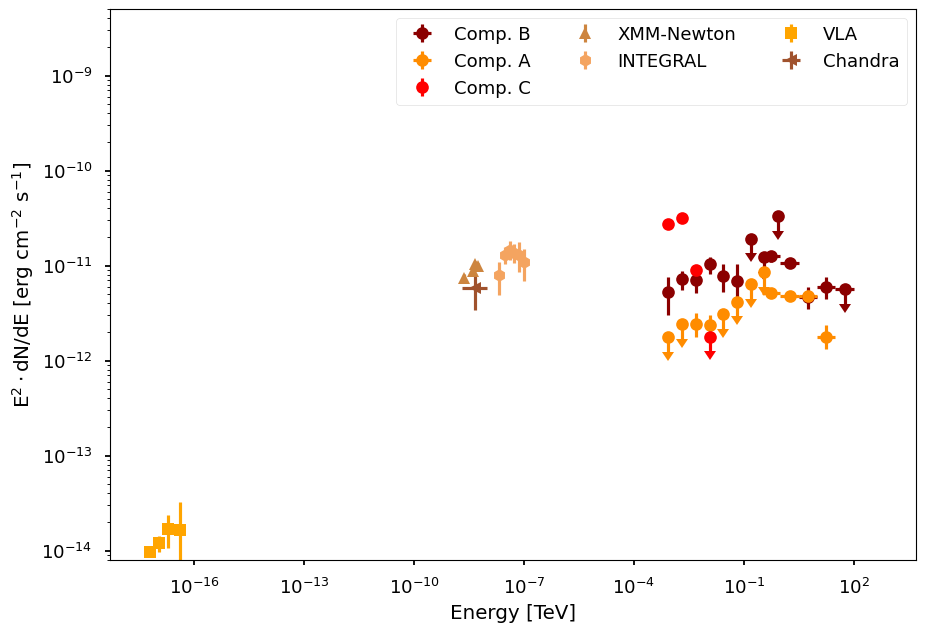

In [20]:
f, ax = plt.subplots() 
draw_observations_data(ax)

## Leptonic Model

In [21]:
model_parameters_assumed_pwn = {
    #fixed parameters
    'br_ind' : 3.0, #pulsar braking index  (Assumed)      associated to the change of the rotation frequency over time
    'ebreak' : 0.1, #TeV                                  below 100GeV, photons due to synchrotron, above almost impossible --> different production, different flux (https://arxiv.org/ftp/arxiv/papers/1108/1108.3797.pdf)
    'alpha0' : 1.5   #                                    spectral index
}
model_parameters_fit_pwn = {
        #fit parameters, lowerbound, upperbound
    'b_now' : [11.4e-6,1e-6,20e-6], #Gauss
    'P0' : [20.2e-3,1e-3,40e-3],
    'theta' : [0.174,0.01,0.3], #converstion frac from pulsar lum to electrons
    'ecut' : [5.69,1.5,10], #log10(E/TeV)
    'alpha' : [2.35,1.7,2.7],
    'time_frac_xray': [0.104,0.,1], #For x-ray (recent electrons)
    'time_frac_pwn': [0.613,0.,1], #For pwn (recent electrons)
    'density' : [1,1,100]#/cm3 #low particle density region
}
define_model_parameters_scales(model_parameters_fit_pwn)
model_parameters_pwn = {**model_parameters_assumed_pwn, **model_parameters_fit_pwn}

In [22]:
#just for sanity check
for key in model_parameters_pwn.keys():
    print(key,model_parameters_pwn[key])
for key in model_parameters_snr.keys():
    print(key,model_parameters_snr[key])

br_ind 3.0
ebreak 0.1
alpha0 1.5
b_now [1.14e-05, 1e-06, 2e-05, 5263157.894736842]
P0 [0.0202, 0.001, 0.04, 2564.102564102564]
theta [0.174, 0.01, 0.3, 344.82758620689657]
ecut [5.69, 1.5, 10, 11.764705882352942]
alpha [2.35, 1.7, 2.7, 99.99999999999997]
time_frac_xray [0.104, 0.0, 1, 100.0]
time_frac_pwn [0.613, 0.0, 1, 100.0]
density [1, 1, 100, 1.0101010101010102]
density_mc [40, 10, 100, 1.1111111111111112]
alpha_p [2.4, 1.9, 2.9, 100.0]
power_p [49, 47, 51, 25.0]
del_alpha [0.0, -1.0, 1.0, 50.0]
k_ep [-4, -7, -1, 16.666666666666668]
b_now_snr [0.0001, 3e-06, 0.0003, 336700.3367003368]


In [23]:
# %%time
# #fit_pwn_model(e_photon, theta_fit, b_now_fit, P0_fit, ecut_fit, alpha_fit, time_frac_fit)
# pwn_fit = util_scipy.pwn_emission(bins, location_pwn, known_properties, model_parameters_pwn)
# pwn_fit_parameters = ['theta','b_now','P0','ecut','alpha', 'time_frac_xray', 'time_frac_pwn']
# pwn_pars = []
# pwn_lower_bounds = []
# pwn_upper_bounds = []
# for par in pwn_fit_parameters:
#     pwn_pars.append(model_parameters_pwn[par][0]*model_parameters_pwn[par][-1])
#     pwn_lower_bounds.append(model_parameters_pwn[par][1]*model_parameters_pwn[par][-1])
#     pwn_upper_bounds.append(model_parameters_pwn[par][2]*model_parameters_pwn[par][-1])
# pwn_bounds = (pwn_lower_bounds, pwn_upper_bounds)

In [24]:
df_x_ray = df_suzaku.copy()
df_x_ray = df_x_ray.append({'e_ref':np.logspace(np.log10(2), np.log10(10), num=3)[1]*10**(-9),
                'sed':np.exp(0.36*10**(-24)*9.8*10**22)*5.6*10**(-12),
                'sed_err':np.exp(0.36*10**(-24)*9.8*10**22)*5.6*10**(-12)*0.36*(1.15)}, ignore_index=True)

/tmp/ipykernel_400942/1338459691.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_x_ray = df_x_ray.append({'e_ref':np.logspace(np.log10(2), np.log10(10), num=3)[1]*10**(-9),


In [25]:
#fermi_thr = 0.02 #TeV
relic_eref = np.concatenate((df_fermi_B['e_ref'][:-1], df_hess_relic[df_hess_relic['is_ul']==False]['e_ref'][1:]))
relic_sed = np.concatenate((np.array(df_fermi_B['sed'][:-1]), np.array(df_hess_relic[df_hess_relic['is_ul']==False]['sed'][1:])), axis=0)
relic_sed_err = np.concatenate((np.array(df_fermi_B['sed_err'][:-1]), np.array(df_hess_relic[df_hess_relic['is_ul']==False]['sed_err'][1:])), axis=0)

pwn_eref = np.concatenate((df_fermi_A['e_ref'][:-1], df_hess_pwn[df_hess_pwn['is_ul']==False]['e_ref'][1:]))
pwn_sed = np.concatenate((np.array(df_fermi_A['sed'][:-1]), np.array(df_hess_pwn[df_hess_pwn['is_ul']==False]['sed'][1:])), axis=0)
pwn_sed_err = np.concatenate((np.array(df_fermi_A['sed_err'][:-1]), np.array(df_hess_pwn[df_hess_pwn['is_ul']==False]['sed_err'][1:])), axis=0)


# data_x = np.array((np.array(df_suzaku['e_ref']), 
#                 pwn_eref*gp.TeV_to_erg,
#                 relic_eref*gp.TeV_to_erg)) #should be in ergs for gamera
# data_y = np.array((np.array(df_suzaku['sed']),
#                 pwn_sed,
#                 relic_sed))
# data_yerr = np.array((np.array(df_suzaku['sed_err']),
#                     pwn_sed_err,
#                     relic_sed_err))
pwn_x = np.array([np.array(df_x_ray['e_ref']), pwn_eref*gp.TeV_to_erg, relic_eref*gp.TeV_to_erg], dtype=object)
pwn_y = np.array([np.array(df_x_ray['sed']), pwn_sed, relic_sed], dtype=object)
pwn_yerr = np.array([np.array(df_x_ray['sed_err']), pwn_sed_err, relic_sed_err], dtype=object)

In [26]:
pwn_y

array([array([7.44961272e-12, 8.88583036e-12, 1.03150954e-11, 9.82847355e-12,
              1.08743593e-11, 7.92174924e-12, 1.30212344e-11, 1.47636214e-11,
              1.37272198e-11, 1.30835309e-11, 1.10213159e-11, 5.80109445e-12]),
       array([ 2.45661513e-12,  2.35235512e-12,  5.09902479e-12,  4.78767637e-12,
               4.82502177e-12,  1.79537864e-12, -2.49553763e-10])                ,
       array([5.31692317e-12, 7.22726571e-12, 7.01140410e-12, 1.03311537e-11,
              7.87304311e-12, 1.25599393e-11, 1.05445560e-11, 4.71100237e-12,
              5.98589343e-12])                                               ],
      dtype=object)

In [27]:
# pwn_x = np.array((data_x[0], data_x[1], data_x[2]))
# pwn_y = np.array((data_y[0], data_y[1], data_y[2]), dtpye=object)
# pwn_yerr = np.array((data_yerr[0], data_yerr[1], data_yerr[2]))

In [28]:
# pwn_x = np.concatenate((np.array(df_x_ray['e_ref']), pwn_eref*gp.TeV_to_erg, relic_eref*gp.TeV_to_erg), axis=0)
# pwn_y = np.concatenate((np.array(df_x_ray['sed']), pwn_sed, relic_sed), axis=0)
# pwn_yerr = np.concatenate((np.array(df_x_ray['sed_err']), pwn_sed_err, relic_sed_err), axis=0)

In [29]:
# pwn_y

In [30]:
# plt.errorbar(pwn_x[0:12], pwn_y[0:12], yerr=pwn_yerr[0:12], linestyle='')
# plt.errorbar(pwn_x[13:17], pwn_y[13:17], yerr=pwn_yerr[13:17], linestyle='')
# plt.errorbar(pwn_x[18:], pwn_y[18:], yerr=pwn_yerr[18:], linestyle='')
# plt.loglog()
# plt.ylim(1e-13)

#### MCMC-Chain

In [56]:
pwn_fit = util.pwn_emission(bins, location_pwn, known_properties, model_parameters_pwn)
pwn_pars = []
pwn_lower_bounds = []
pwn_upper_bounds = []
for par in pwn_fit_parameters:
    pwn_pars.append(model_parameters_pwn[par][0]*model_parameters_pwn[par][-1])
    pwn_lower_bounds.append(model_parameters_pwn[par][1]*model_parameters_pwn[par][-1])
    pwn_upper_bounds.append(model_parameters_pwn[par][2]*model_parameters_pwn[par][-1])
pwn_bounds = (pwn_lower_bounds, pwn_upper_bounds)
#mcmc_result_pwn = util.run_mcmc(7,pwn_pars,pwn_fit.log_prob_pwn,pwn_x,pwn_y,pwn_yerr)

In [57]:
x=0

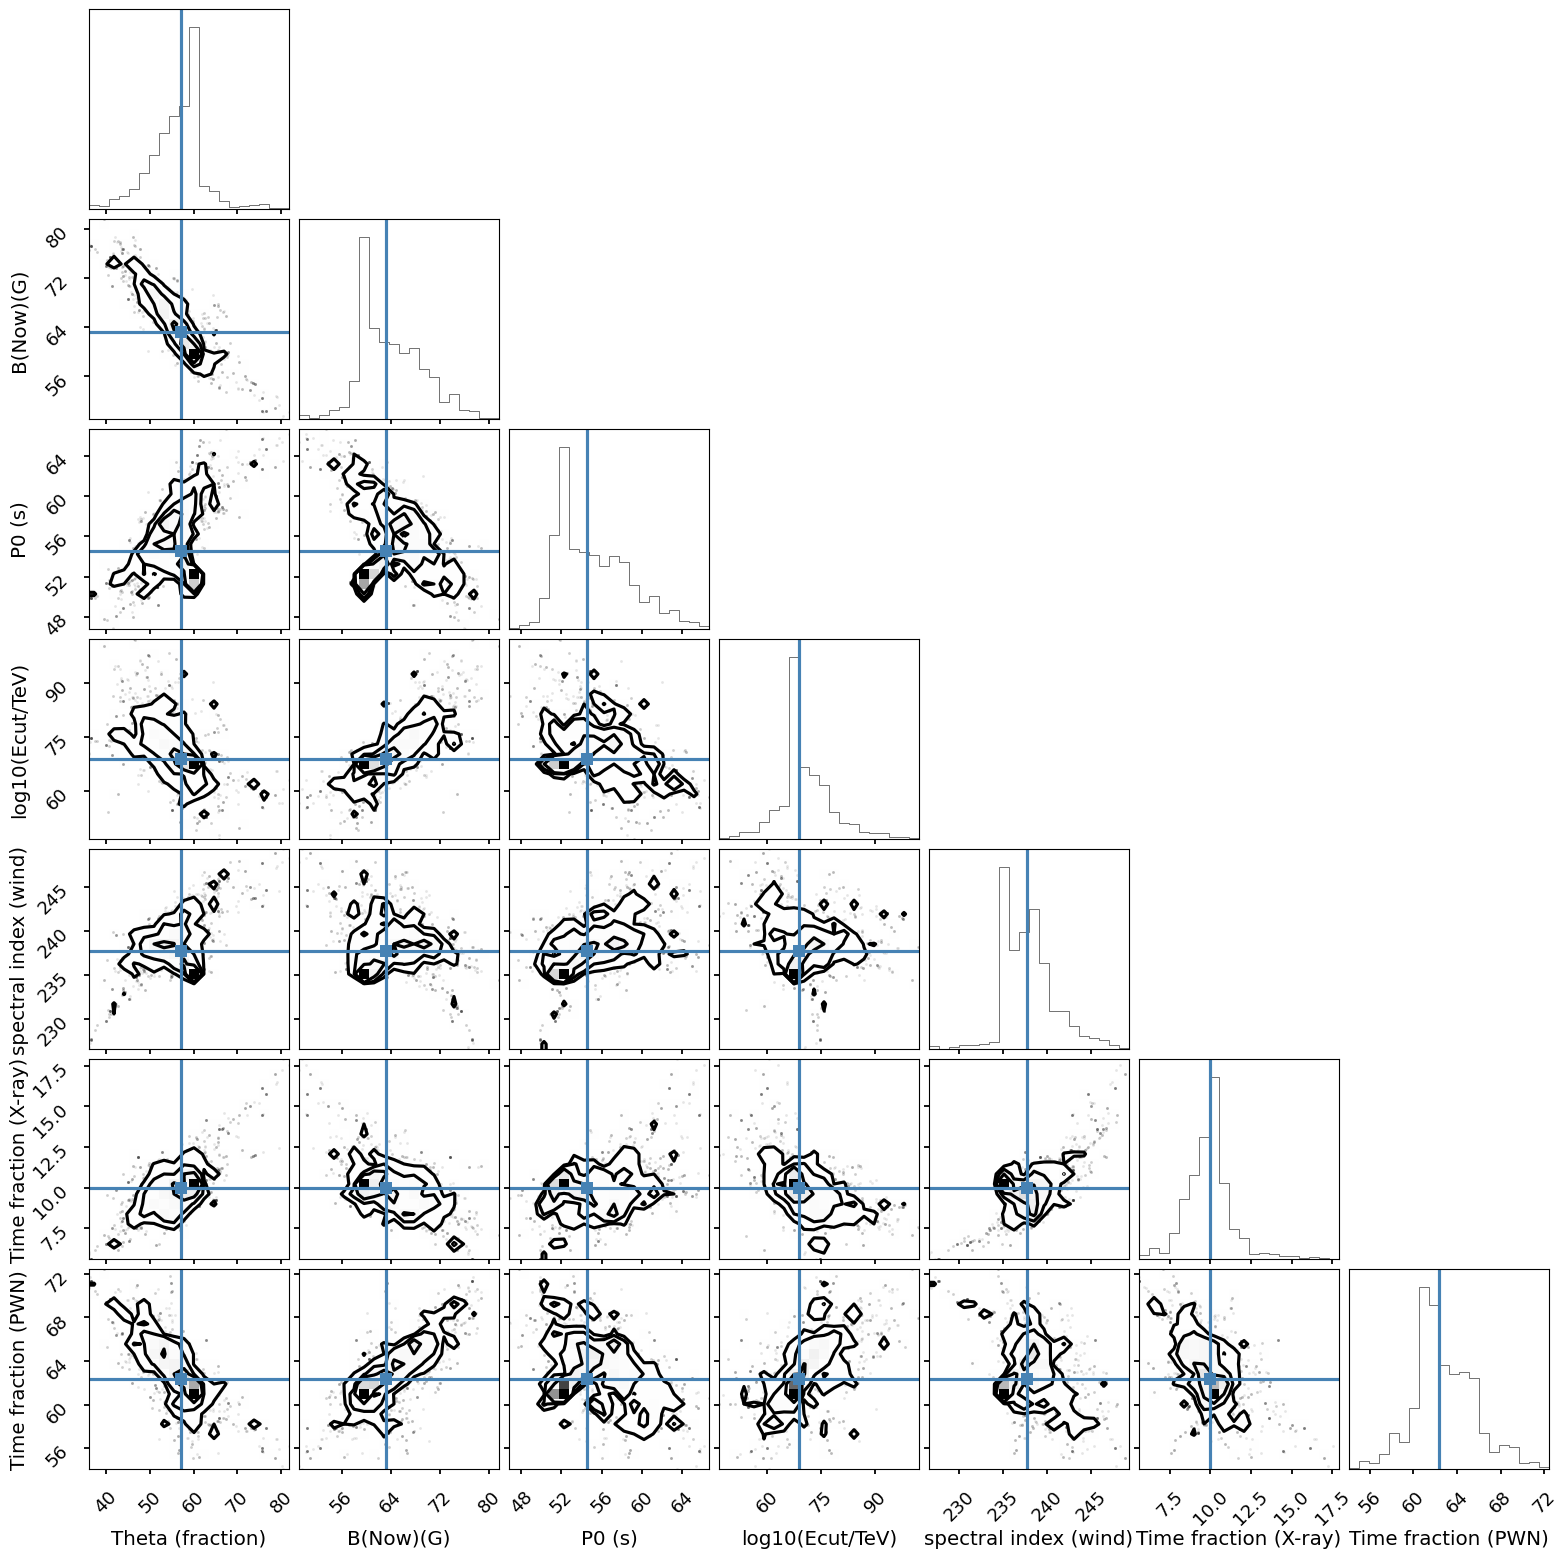

In [58]:
pwn_fit_parameters = ['theta','b_now','P0','ecut','alpha','time_frac_xray','time_frac_pwn']
pwn_labels = ["Theta (fraction)", "B(Now)(G)", "P0 (s)", "log10(Ecut/TeV)", "spectral index (wind)","Time fraction (X-ray)", "Time fraction (PWN)"]
if os.path.isfile(f'/lfs/l7/hess/users/twach/modeling/Modeling/data_points/mcmc_result_pwn_new_chandra.npy'):
    with open('/lfs/l7/hess/users/twach/modeling/Modeling/data_points/mcmc_result_pwn_new_chandra.npy', 'rb') as f:
        mcmc_result_pwn = np.load(f)
        mcmc_pwn_fit_results, mcmc_pwn_fit_results_err_high, mcmc_pwn_fit_results_err_low = util.mcmc_results("pwn", pwn_labels, pwn_fit_parameters, 
                                                                                          model_parameters_pwn, mcmc_result_pwn)
        plt.savefig(f"/lfs/l7/hess/users/twach/modeling/Modeling/pwn_cornerplot_new_chandra.png", bbox_inches='tight')
        plt.savefig(f"/lfs/l7/hess/users/twach/modeling/pwn_cornerplot_new_chandra.pdf", bbox_inches='tight')
        model_parameters_pwn_after_fit = model_parameters_pwn.copy()
        #because we are using already fitted results get the pwn_fit object with the best fit parameter values
        for i,par in enumerate(pwn_fit_parameters):
            model_parameters_pwn_after_fit[par][0] = mcmc_pwn_fit_results[i]/model_parameters_pwn_after_fit[par][-1]
        pwn_fit = util.pwn_emission(bins, location_pwn, known_properties, model_parameters_pwn_after_fit)
else:
    pwn_fit = util.pwn_emission(bins, location_pwn, known_properties, model_parameters_pwn)
    pwn_pars = []
    pwn_lower_bounds = []
    pwn_upper_bounds = []
    for par in pwn_fit_parameters:
        pwn_pars.append(model_parameters_pwn[par][0]*model_parameters_pwn[par][-1])
        pwn_lower_bounds.append(model_parameters_pwn[par][1]*model_parameters_pwn[par][-1])
        pwn_upper_bounds.append(model_parameters_pwn[par][2]*model_parameters_pwn[par][-1])
    pwn_bounds = (pwn_lower_bounds, pwn_upper_bounds)
    mcmc_result_pwn = util.run_mcmc(7,pwn_pars,pwn_fit.log_prob_pwn,pwn_x,pwn_y,pwn_yerr)
    with open('/lfs/l7/hess/users/twach/modeling/Modeling/data_points/mcmc_result_pwn_new_chandra.npy', 'wb') as f:
        np.save(f, mcmc_result_pwn)
    mcmc_pwn_fit_results, mcmc_pwn_fit_results_err_high, mcmc_pwn_fit_results_err_low = util.mcmc_results("pwn", pwn_labels, pwn_fit_parameters, 
                                                                                          model_parameters_pwn, mcmc_result_pwn)
    plt.savefig(f"/lfs/l7/hess/users/twach/modeling/Modeling/pwn_cornerplot_new_chandra.png", bbox_inches='tight')
    plt.savefig(f"/lfs/l7/hess/users/twach/modeling/Modeling/pwn_cornerplot_new_chandra.pdf", bbox_inches='tight')

In [59]:
for i,par in enumerate(pwn_fit_parameters):
    model_parameters_pwn_after_fit[par][0] = mcmc_pwn_fit_results[i]/model_parameters_pwn_after_fit[par][-1]
    high = mcmc_pwn_fit_results_err_high[i]/model_parameters_pwn_after_fit[par][-1]
    low = mcmc_pwn_fit_results_err_low[i]/model_parameters_pwn_after_fit[par][-1]
#     print(par,":", model_parameters_pwn_after_fit[par][0], '+', high, '-', low)
    print('results:', par, '=', model_parameters_pwn_after_fit[par][0]-low, '-', model_parameters_pwn_after_fit[par][0]+high)

results: theta = 0.14781232630526542 - 0.17415406469425898
results: b_now = 1.1357017717935583e-05 - 1.3183167953793062e-05
results: P0 = 0.020192519856522293 - 0.022966665587999608
results: ecut = 5.574739339545526 - 6.5241636183747485
results: alpha = 2.350988620136114 - 2.40379601292102
results: time_frac_xray = 0.0866253562381304 - 0.10857665818495486
results: time_frac_pwn = 0.606250586668539 - 0.6546287959795946


In [60]:
true_age = pwn_fit.calculate_true_age()/1e3
xray_age = pwn_fit.calculate_true_age()*mcmc_pwn_fit_results[-2]/model_parameters_fit_pwn['time_frac_xray'][-1]/1e3
xray_age_errp = pwn_fit.calculate_true_age()*mcmc_pwn_fit_results_err_high[-2]/model_parameters_fit_pwn['time_frac_xray'][-1]/1e3
xray_age_errn = pwn_fit.calculate_true_age()*mcmc_pwn_fit_results_err_low[-2]/model_parameters_fit_pwn['time_frac_xray'][-1]/1e3
print("True age (kyrs): {:.1f}".format(true_age))
print("Recent electrons (X-ray) (kyrs): {:.1f} + {:.1f} - {:.1f}".format(xray_age,xray_age_errp,xray_age_errn))
pwn_age = pwn_fit.calculate_true_age()*mcmc_pwn_fit_results[-1]/model_parameters_fit_pwn['time_frac_pwn'][-1]/1e3
pwn_age_errp = pwn_fit.calculate_true_age()*mcmc_pwn_fit_results_err_high[-1]/model_parameters_fit_pwn['time_frac_pwn'][-1]/1e3
pwn_age_errn = pwn_fit.calculate_true_age()*mcmc_pwn_fit_results_err_low[-1]/model_parameters_fit_pwn['time_frac_pwn'][-1]/1e3
print("Recent electrons (PWN) (kyrs): {:.1f} + {:.1f} - {:.1f}".format(pwn_age,pwn_age_errp,pwn_age_errn))
relic_age = true_age - pwn_age
print("Relic age (kyrs): {:.1f}".format(relic_age))

True age (kyrs): 4.3
Recent electrons (X-ray) (kyrs): 0.4 + 0.0 - 0.1
Recent electrons (PWN) (kyrs): 2.7 + 0.1 - 0.1
Relic age (kyrs): 1.6


In [61]:
high_results_pwn = mcmc_pwn_fit_results + mcmc_pwn_fit_results_err_high
low_results_pwn = mcmc_pwn_fit_results - mcmc_pwn_fit_results_err_low

In [62]:
pwn_sed_xray, pwn_sed_pwn, pwn_sed_relic, fp_pwn, fr_pwn = util.get_pwn_sed(pwn_fit, mcmc_pwn_fit_results)
pwn_sed_xray_high, pwn_sed_pwn_high, pwn_sed_relic_high, fp_pwn_high, fr_pwn_high = util.get_pwn_sed(pwn_fit, high_results_pwn)
pwn_sed_xray_low, pwn_sed_pwn_low, pwn_sed_relic_low, fp_pwn_low, fr_pwn_low = util.get_pwn_sed(pwn_fit, low_results_pwn)

Particles::SetMembers: Time (1627.27yrs vs {1,1627.09}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 
Particles::SetMembers: Time (1419.78yrs vs {1,1419.57}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 
Particles::SetMembers: Time (1750.12yrs vs {1,1749.49}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 
Particles::SetMembers: Time (1749.77yrs vs {1,1749.49}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g.

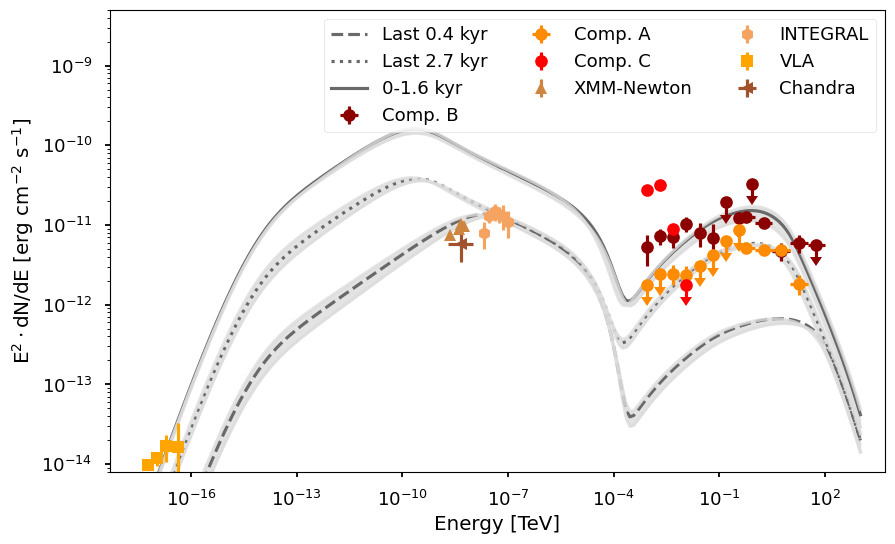

In [63]:
f, ax = plt.subplots(1,figsize=(10,6))     

ax.plot(pwn_sed_xray[:,0],pwn_sed_xray[:,1],linestyle="--",color='dimgray',label="Last {:.1f} kyr".format(xray_age))
ax.plot(pwn_sed_xray_high[:,0],pwn_sed_xray_high[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.plot(pwn_sed_xray_low[:,0],pwn_sed_xray_low[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.fill_between(pwn_sed_xray_low[:,0], pwn_sed_xray_high[:,1], pwn_sed_xray_low[:,1], color='gainsboro', alpha=0.8)


ax.plot(pwn_sed_pwn[:,0],pwn_sed_pwn[:,1],linestyle=":",color='dimgray',label="Last {:.1f} kyr".format(pwn_age))
ax.plot(pwn_sed_pwn_high[:,0],pwn_sed_pwn_high[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.plot(pwn_sed_pwn_low[:,0],pwn_sed_pwn_low[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.fill_between(pwn_sed_pwn_low[:,0], pwn_sed_pwn_high[:,1], pwn_sed_pwn_low[:,1], color='gainsboro', alpha=0.8)


ax.plot(pwn_sed_relic[:,0],pwn_sed_relic[:,1],linestyle="-",color='dimgray', label="0-{:.1f} kyr".format(relic_age))
ax.plot(pwn_sed_relic_high[:,0],pwn_sed_relic_high[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.plot(pwn_sed_relic_low[:,0],pwn_sed_relic_low[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.fill_between(pwn_sed_relic_low[:,0], pwn_sed_relic_high[:,1], pwn_sed_relic_low[:,1], color='gainsboro', alpha=0.8)


draw_observations_data(ax)
fig = plt.gcf()
save(fig, 'leptonic_model_mcmc_6kpc_new_points_chandra')

In [64]:
def draw_observations_data(ax):
    ax.errorbar(df_hess_relic['e_ref'], df_hess_relic['sed'], 
                xerr = [df_hess_relic['e_ref'] - df_hess_relic['e_min'], df_hess_relic['e_max'] - df_hess_relic['e_ref']], 
                yerr = [df_hess_relic['sed_errn'], df_hess_relic['sed_errp']], 
                marker='o', linestyle='None', label ='Comp. B', uplims=df_hess_relic['is_ul'], color='darkred')
    ax.errorbar(df_hess_pwn['e_ref'], df_hess_pwn['sed'], 
                xerr = [df_hess_pwn['e_ref'] - df_hess_pwn['e_min'], df_hess_pwn['e_max'] - df_hess_pwn['e_ref']], 
                yerr = [df_hess_pwn['sed_errn'], df_hess_pwn['sed_errp']], 
                marker='o', linestyle='None', label ='Comp. A', uplims=df_hess_pwn['is_ul'], color='darkorange')
    
    ax.errorbar(df_fermi_B['e_ref'], df_fermi_B['sed'], 
                yerr = df_fermi_B['sed_err'], 
                marker='o', linestyle='None', color='darkred')
    ax.errorbar(df_fermi_B_ul['e_ref'], df_fermi_B_ul['sed'],  
                yerr = df_fermi_B_ul['sed_err'],
                marker='o', linestyle='None', uplims=True, color='darkred')
    
    ax.errorbar(df_fermi_A['e_ref'], df_fermi_A['sed'], 
                yerr = df_fermi_A['sed_err'], 
                marker='o', linestyle='None', color='darkorange')
    ax.errorbar(df_fermi_A_ul['e_ref'], df_fermi_A_ul['sed'],  
                yerr = df_fermi_A_ul['sed_err'],
                marker='o', linestyle='None', uplims=True, color='darkorange')
    
    ax.errorbar(df_fermi_C['e_ref'], df_fermi_C['sed'], 
                yerr = df_fermi_C['sed_err'], 
                marker='o', linestyle='None', label ='Comp. C', color='red')
    ax.errorbar(df_fermi_C_ul['e_ref'], df_fermi_C_ul['sed'],  
                yerr = df_fermi_C_ul['sed_err'],
                marker='o', linestyle='None', uplims=True, color='red')
    
    ax.legend(ncol=3, loc=1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(5e-19,5e3)
    ax.set_ylim(bottom=8e-15, top=5*10**-9)
    ax.set_xlabel("Energy [TeV]")
    ax.set_ylabel("E"+r"$^2 \cdot$"+"dN/dE [erg cm"+r"$^{-2}$"+" s"+r"$^{-1}$""]")

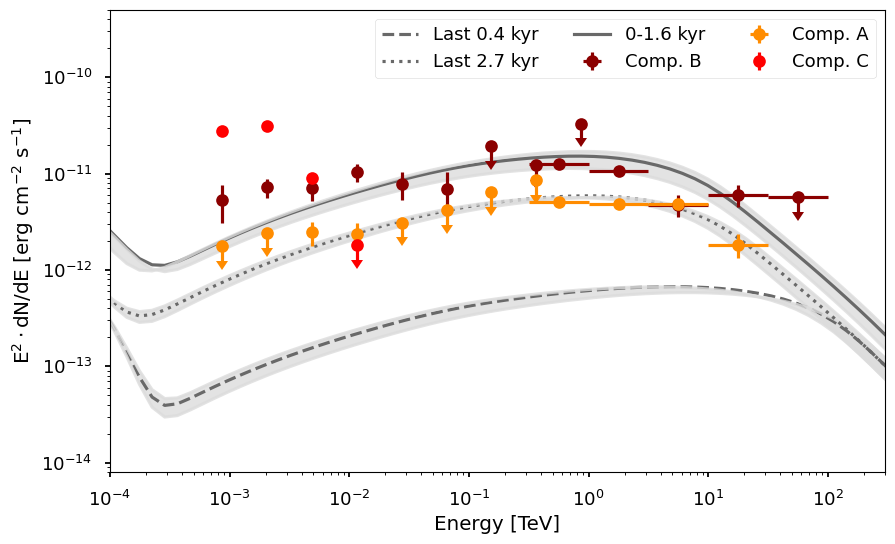

In [65]:
f, ax = plt.subplots(1,figsize=(10,6))     

ax.plot(pwn_sed_xray[:,0],pwn_sed_xray[:,1],linestyle="--",color='dimgray',label="Last {:.1f} kyr".format(xray_age))
ax.plot(pwn_sed_xray_high[:,0],pwn_sed_xray_high[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.plot(pwn_sed_xray_low[:,0],pwn_sed_xray_low[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.fill_between(pwn_sed_xray_low[:,0], pwn_sed_xray_high[:,1], pwn_sed_xray_low[:,1], color='gainsboro', alpha=0.8)


ax.plot(pwn_sed_pwn[:,0],pwn_sed_pwn[:,1],linestyle=":",color='dimgray',label="Last {:.1f} kyr".format(pwn_age))
ax.plot(pwn_sed_pwn_high[:,0],pwn_sed_pwn_high[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.plot(pwn_sed_pwn_low[:,0],pwn_sed_pwn_low[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.fill_between(pwn_sed_pwn_low[:,0], pwn_sed_pwn_high[:,1], pwn_sed_pwn_low[:,1], color='gainsboro', alpha=0.8)


ax.plot(pwn_sed_relic[:,0],pwn_sed_relic[:,1],linestyle="-",color='dimgray', label="0-{:.1f} kyr".format(relic_age))
ax.plot(pwn_sed_relic_high[:,0],pwn_sed_relic_high[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.plot(pwn_sed_relic_low[:,0],pwn_sed_relic_low[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.fill_between(pwn_sed_relic_low[:,0], pwn_sed_relic_high[:,1], pwn_sed_relic_low[:,1], color='gainsboro', alpha=0.8)


draw_observations_data(ax)
plt.xlim(1e-04,3e02)
plt.ylim(top=5e-10)

fig = plt.gcf()
save(fig, 'leptonic_model_mcmc_6kpc_new_points_cutout_chandra')

## both models:

In [55]:
######problem!
pwn_residuals = []
for j in range(0,len(df_hess_pwn['e_ref'])):
    for i in range(0,len(pwn_sed_pwn[:,0])):
        if df_hess_pwn['e_ref'][j]- 0.1*df_hess_pwn['e_ref'][j] <= pwn_sed_pwn[:,0][i] <= df_hess_pwn['e_ref'][j] + df_hess_pwn['e_ref'][j]*0.1:
            residuals = np.divide(pwn_sed_pwn[:,1][i] - df_hess_pwn['sed'][j], df_hess_pwn['sed'][j])
            residual_energy = df_hess_pwn['e_ref'][j]
            residual_error = 1- (df_hess_pwn['sed'][j] - df_hess_pwn['sed_err'][j])/df_hess_pwn['sed'][j]
            pwn_residuals.append([residual_energy, residuals, residual_error])
            
pwn_residuals = np.array(pwn_residuals)

In [61]:
hess_halo_residuals = []
for j in range(0,len(df_hess_relic['e_ref'])-1):
    for i in range(0,len(pwn_sed_relic[:,0])):
        if df_hess_relic['e_ref'][j]- 0.12*df_hess_relic['e_ref'][j] <= pwn_sed_relic[:,0][i] <= df_hess_relic['e_ref'][j] + df_hess_relic['e_ref'][j]*0.12:
            residuals = np.divide(pwn_sed_relic[:,1][i] - df_hess_relic['sed'][j], df_hess_relic['sed'][j])
            residual_energy = df_hess_relic['e_ref'][j]
            residual_error = 1- (df_hess_relic['sed'][j] - df_hess_relic['sed_err'][j])/df_hess_relic['sed'][j]
            hess_halo_residuals.append([residual_energy, residuals, residual_error])
        
            
hess_halo_residuals = np.array(hess_halo_residuals)

/tmp/ipykernel_335/3519757046.py:6: RuntimeWarning: invalid value encountered in divide
  residuals = np.divide(pwn_sed_relic[:,1][i] - df_hess_relic['sed'][j], df_hess_relic['sed'][j])
/tmp/ipykernel_335/3519757046.py:19: UserWarning: Warning: converting a masked element to nan.
  hess_halo_residuals = np.array(hess_halo_residuals)


In [66]:
fermi_thr = 0.0001
fermi_halo_residuals = []
for j in range(0,len(np.array(df_fermi_B[df_fermi_B['e_ref'] > fermi_thr]['e_ref']))):
    for i in range(0,len(pwn_sed_relic[:,0])):
        if np.array(df_fermi_B[df_fermi_B['e_ref'] > fermi_thr]['e_ref'])[j]- 0.12*np.array(df_fermi_B[df_fermi_B['e_ref'] > fermi_thr]['e_ref'])[j] <= pwn_sed_relic[:,0][i] <= np.array(df_fermi_B[df_fermi_B['e_ref'] > fermi_thr]['e_ref'])[j] + np.array(df_fermi_B[df_fermi_B['e_ref'] > fermi_thr]['e_ref'])[j]*0.12:
            residuals = np.divide(pwn_sed_relic[:,1][i] - np.array(df_fermi_B[df_fermi_B['e_ref'] > fermi_thr]['sed'])[j], np.array(df_fermi_B[df_fermi_B['e_ref'] > fermi_thr]['sed'])[j])
            residual_energy = np.array(df_fermi_B[df_fermi_B['e_ref'] > fermi_thr]['e_ref'])[j]
            residual_error = 1- (np.array(df_fermi_B[df_fermi_B['e_ref'] > fermi_thr]['sed'])[j] - np.array(df_fermi_B[df_fermi_B['e_ref'] > fermi_thr]['sed_err'])[j])/np.array(df_fermi_B[df_fermi_B['e_ref'] > fermi_thr]['sed'])[j]
            fermi_halo_residuals.append([residual_energy, residuals, residual_error])
fermi_halo_residuals = np.array(fermi_halo_residuals)

In [70]:
fermi_thr = 0.0001
fermi_pwn_residuals = []
for j in range(0,len(np.array(df_fermi_A[df_fermi_A['e_ref'] > fermi_thr]['e_ref']))):
    for i in range(0,len(pwn_sed_pwn[:,0])):
        if np.array(df_fermi_A[df_fermi_A['e_ref'] > fermi_thr]['e_ref'])[j]- 0.12*np.array(df_fermi_A[df_fermi_A['e_ref'] > fermi_thr]['e_ref'])[j] <= pwn_sed_pwn[:,0][i] <= np.array(df_fermi_A[df_fermi_A['e_ref'] > fermi_thr]['e_ref'])[j] + np.array(df_fermi_A[df_fermi_A['e_ref'] > fermi_thr]['e_ref'])[j]*0.12:
            residuals = np.divide(pwn_sed_pwn[:,1][i] - np.array(df_fermi_A[df_fermi_A['e_ref'] > fermi_thr]['sed'])[j], np.array(df_fermi_A[df_fermi_A['e_ref'] > fermi_thr]['sed'])[j])
            residual_energy = np.array(df_fermi_A[df_fermi_A['e_ref'] > fermi_thr]['e_ref'])[j]
            residual_error = 1- (np.array(df_fermi_A[df_fermi_A['e_ref'] > fermi_thr]['sed'])[j] - np.array(df_fermi_A[df_fermi_A['e_ref'] > fermi_thr]['sed_err'])[j])/np.array(df_fermi_A[df_fermi_A['e_ref'] > fermi_thr]['sed'])[j]
            fermi_pwn_residuals.append([residual_energy, residuals, residual_error])
fermi_pwn_residuals = np.array(fermi_pwn_residuals)

In [71]:
fermi_pwn_residuals

array([[ 0.00486968, -0.22354518,  0.2857272 ],
       [ 0.01154782,  0.05071553,  0.28976395],
       [ 0.86596431, -1.01227367, -0.78911669]])

In [76]:
def draw_observations_data(ax):
    ax.errorbar(df_hess_relic['e_ref'], df_hess_relic['sed'], 
                xerr = [df_hess_relic['e_ref'] - df_hess_relic['e_min'], df_hess_relic['e_max'] - df_hess_relic['e_ref']], 
                yerr = [df_hess_relic['sed_errn'], df_hess_relic['sed_errp']], 
                marker='o', linestyle='None', label ='Comp. B', uplims=df_hess_relic['is_ul'], color='darkred')
    ax.errorbar(df_hess_pwn['e_ref'], df_hess_pwn['sed'], 
                xerr = [df_hess_pwn['e_ref'] - df_hess_pwn['e_min'], df_hess_pwn['e_max'] - df_hess_pwn['e_ref']], 
                yerr = [df_hess_pwn['sed_errn'], df_hess_pwn['sed_errp']], 
                marker='o', linestyle='None', label ='Comp. A', uplims=df_hess_pwn['is_ul'], color='darkorange')
    
    ax.errorbar(df_fermi_B['e_ref'], df_fermi_B['sed'], 
                yerr = df_fermi_B['sed_err'], 
                marker='o', linestyle='None', color='darkred')
    ax.errorbar(df_fermi_B_ul['e_ref'], df_fermi_B_ul['sed'],  
                yerr = df_fermi_B_ul['sed_err'],
                marker='o', linestyle='None', uplims=True, color='darkred')
    
    ax.errorbar(df_fermi_A['e_ref'], df_fermi_A['sed'], 
                yerr = df_fermi_A['sed_err'], 
                marker='o', linestyle='None', color='darkorange')
    ax.errorbar(df_fermi_A_ul['e_ref'], df_fermi_A_ul['sed'],  
                yerr = df_fermi_A_ul['sed_err'],
                marker='o', linestyle='None', uplims=True, color='darkorange')
    
    
    ax.legend(ncol=3, loc=1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(5e-19,5e3)
    ax.set_ylim(bottom=8e-15, top=5*10**-9)
    ax.set_xlabel("Energy [TeV]")
    ax.set_ylabel("E"+r"$^2 \cdot$"+"dN/dE [erg cm"+r"$^{-2}$"+" s"+r"$^{-1}$""]")

<Figure size 1560x1072.5 with 0 Axes>

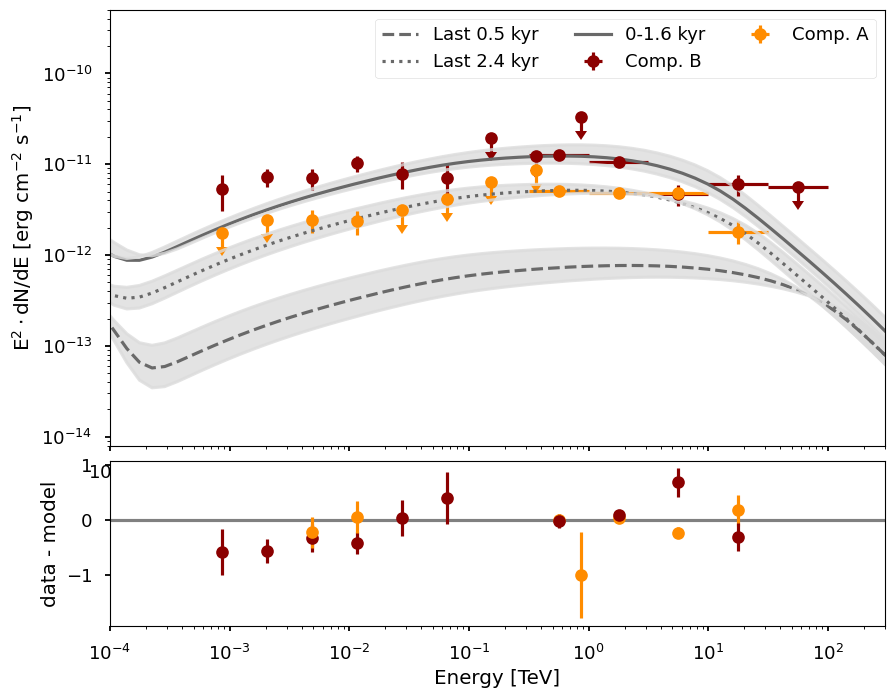

In [84]:
#with open('/lfs/l7/hess/users/twach/modeling/Modeling/data_points/pwn_seds.npy', 'rb') as f:
#    pwn_seds = np.load(f)
#with open('/lfs/l7/hess/users/twach/modeling/Modeling/data_points/snr_seds.npy', 'rb') as f:
#    snr_seds = np.load(f)
#with open('/lfs/l7/hess/users/twach/modeling/Modeling/data_points/residual_seds.npy', 'rb') as f:
#    residual_seds = np.load(f, allow_pickle=True)

    
fig=plt.figure( dpi= 150)
plt.rcParams.update({'font.size': 9})
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"    
    
    
f, ax = plt.subplots(1,figsize=(10,8))   
gs = GridSpec(7, 1)
#upper subplot:
ax = plt.subplot(gs[:5, :])
#observation:
draw_observations_data(ax)
#models:

ax.plot(pwn_sed_xray[:,0],pwn_sed_xray[:,1],linestyle="--",color='dimgray',label="Last {:.1f} kyr".format(xray_age))
ax.plot(pwn_sed_xray_high[:,0],pwn_sed_xray_high[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.plot(pwn_sed_xray_low[:,0],pwn_sed_xray_low[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.fill_between(pwn_sed_xray_low[:,0], pwn_sed_xray_high[:,1], pwn_sed_xray_low[:,1], color='gainsboro', alpha=0.8)


ax.plot(pwn_sed_pwn[:,0],pwn_sed_pwn[:,1],linestyle=":",color='dimgray',label="Last {:.1f} kyr".format(pwn_age))
ax.plot(pwn_sed_pwn_high[:,0],pwn_sed_pwn_high[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.plot(pwn_sed_pwn_low[:,0],pwn_sed_pwn_low[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.fill_between(pwn_sed_pwn_low[:,0], pwn_sed_pwn_high[:,1], pwn_sed_pwn_low[:,1], color='gainsboro', alpha=0.8)


ax.plot(pwn_sed_relic[:,0],pwn_sed_relic[:,1],linestyle="-",color='dimgray', label="0-{:.1f} kyr".format(relic_age))
ax.plot(pwn_sed_relic_high[:,0],pwn_sed_relic_high[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.plot(pwn_sed_relic_low[:,0],pwn_sed_relic_low[:,1],linestyle="-",color='gainsboro', alpha=0.8)
ax.fill_between(pwn_sed_relic_low[:,0], pwn_sed_relic_high[:,1], pwn_sed_relic_low[:,1], color='gainsboro', alpha=0.8)

ax.legend(ncol=3, loc=1)
ax.set_xlim(1e-04,3e02)
ax.set_ylim(top=5e-10)
    
########################################################################################################################
#second subplot:
#residuals
ax_residuals = plt.subplot(gs[5:, :], sharex=ax)
ax_residuals = plt.gca()
x_min, x_max = ax_residuals.get_xlim()
ax_residuals.hlines(0, x_min, x_max, ls="-", color="grey")
ax_residuals.set_ylabel("data - model")
ax_residuals.set_xlabel("Energy [TeV]")
    
#x-ray
ax_residuals.errorbar(pwn_residuals[:,0][0:-1], pwn_residuals[:,1][0:-1], yerr=pwn_residuals[:,2][0:-1], color='darkorange',marker='o',capsize = 5, linestyle='None')
ax_residuals.errorbar(hess_halo_residuals[:,0], hess_halo_residuals[:,1], yerr=hess_halo_residuals[:,2], color='darkred',marker='o',capsize = 5, linestyle='None')
ax_residuals.errorbar(fermi_halo_residuals[:,0], fermi_halo_residuals[:,1], yerr=fermi_halo_residuals[:,2], color='darkred',marker='o',capsize = 5, linestyle='None')
ax_residuals.errorbar(fermi_pwn_residuals[:,0], fermi_pwn_residuals[:,1], yerr=fermi_pwn_residuals[:,2], color='darkorange',marker='o',capsize = 5, linestyle='None')

fig = plt.gcf()
save(fig, 'leptonic_model_mcmc_6kpc_new_points_cutout_deviation')

## Diagnosic plots:

In [66]:
total_sed = fr_pwn.GetTotalSED() # SED, E^2dNdE (erg/s/cm^2) vs E (TeV)
pp_sed = fr_pwn.GetPPSED() 
synch_sed = fr_pwn.GetSynchrotronSED() 
brems_sed = fr_pwn.GetBremsstrahlungSED()
ic_sed = fr_pwn.GetICSED()

total_sed = np.array(total_sed)
synch_sed = np.array(synch_sed)
brems_sed = np.array(brems_sed)
ic_sed = np.array(ic_sed)

In [67]:
ic_sed_low = np.array(fr_pwn_low.GetICSED())
ic_sed_high = np.array(fr_pwn_high.GetICSED())

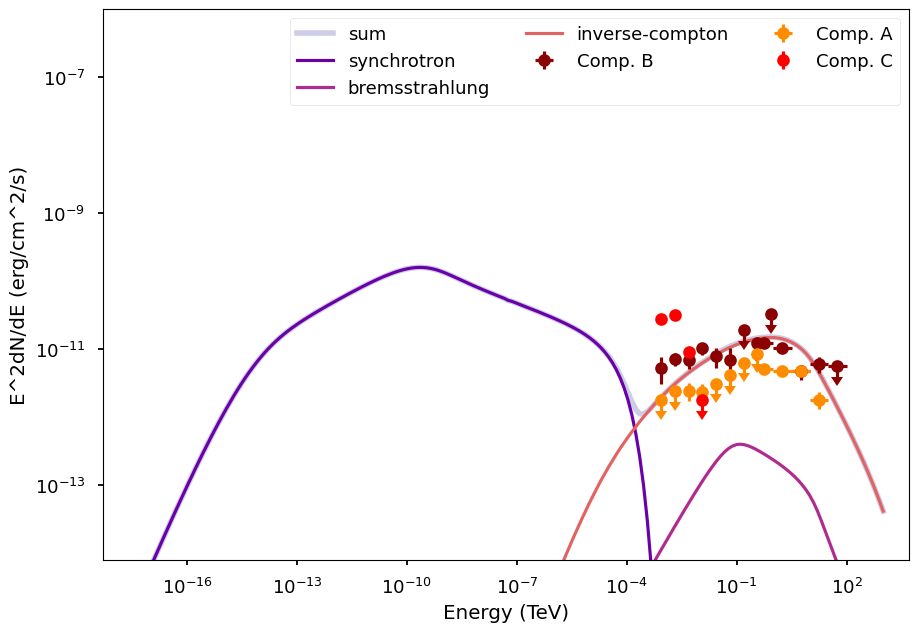

In [68]:
f, ax = plt.subplots() 
ax.set_prop_cycle('color',plt.get_cmap('plasma')(np.linspace(0., .8, 5)))  #
plt.loglog(total_sed[:,0],total_sed[:,1],lw=4,alpha=0.2,label="sum")
plt.loglog(synch_sed[:,0],synch_sed[:,1],label="synchrotron")
plt.loglog(brems_sed[:,0],brems_sed[:,1],label="bremsstrahlung")
plt.loglog(ic_sed[:,0],ic_sed[:,1],label="inverse-compton")
draw_observations_data(ax)
plt.ylim(top=10**-6)
plt.xlabel("Energy (TeV)")
plt.ylabel("E^2dN/dE (erg/cm^2/s)")
fig = plt.gcf()
save(fig, 'leptonic_model_mcmc_components_6kpc_no_cutoff')

In [69]:
def plot_rad_fields(fr, ax, label):
    fields={
    'cmb':[0,2.5e-3], #eV
    'IR':[2.5e-3,2e-1], #eV
    'optical':[2e-1,10], #eV
    }
    #Extracting the used radiation fields 
    rad_fields = np.array(fr.GetTargetPhotons())
    rad_fields_flux = rad_fields[:,1] / gp.eV_to_erg
    rad_fields[:,1] *= rad_fields[:,0]**2 / gp.eV_to_erg
    rad_fields[:,0] /= gp.eV_to_erg
    int_rad_field_density = fu.Integrate(list(zip(rad_fields[:,0],rad_fields[:,1])))
    ax.loglog(rad_fields[:,0],rad_fields[:,1],label=label)
    for fd in fields.keys():
        rad_fields_energy = np.array(rad_fields[:,0])
        rad_fields_density = np.array(rad_fields[:,1])
        energy_range = rad_fields_energy[(rad_fields_energy > fields[fd][0]) & (rad_fields_energy <= fields[fd][1])]
        field_density = rad_fields_density[(rad_fields_energy > fields[fd][0]) & (rad_fields_energy <= fields[fd][1])]
        int_density = fu.Integrate(list(zip(energy_range,field_density)))
        temp = np.power(int_density/0.0047225517614,0.25) #Kelvin      
        print(fd, "{:.1e} eV/cm3".format(int_density), "{:.1e} K".format(temp))
    print("int_rad_field_density",label, int_rad_field_density, "eV/cm3")
    return int_rad_field_density

cmb 2.2e-04 eV/cm3 4.7e-01 K
IR 4.1e-02 eV/cm3 1.7e+00 K
optical 3.1e+00 eV/cm3 5.0e+00 K
int_rad_field_density PWN 3.271774377751244 eV/cm3


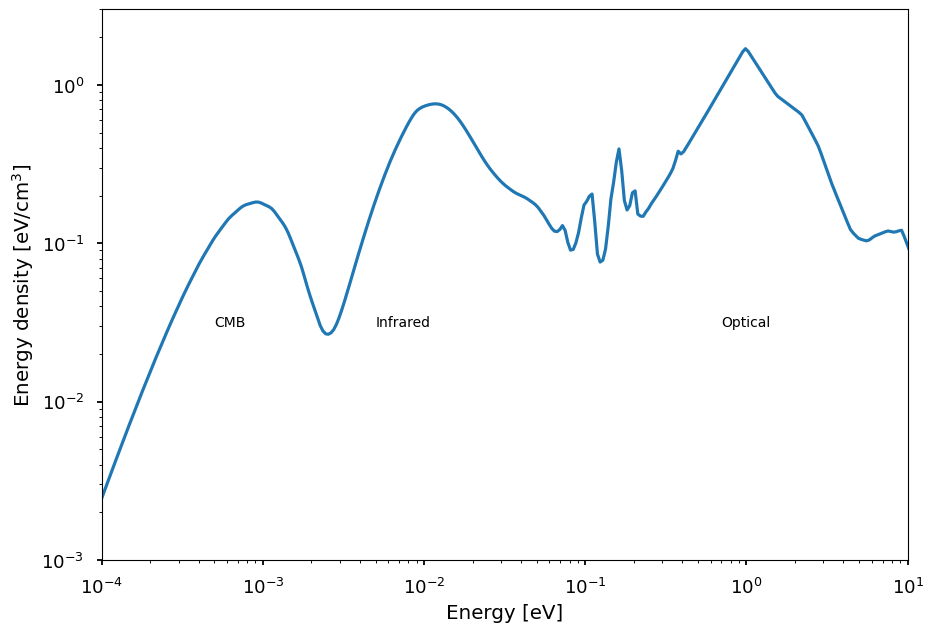

In [70]:
f, ax = plt.subplots() 
int_rad_field_density_pwn = plot_rad_fields(fr_pwn, ax, "PWN")
#int_rad_field_density_snr = plot_rad_fields(fr_snr, ax, "SNR")
plt.xlabel("Energy [eV]")
plt.ylabel("Energy density [eV/cm$^3$]")
plt.text(5e-4,3e-2,'CMB')
plt.text(5e-3,3e-2,'Infrared')
plt.text(7e-1,3e-2,'Optical')
plt.axis([1e-4,1e1,1e-3,3e0])
fig = plt.gcf()
save(fig, 'Radiation_fields_6kpc_new')

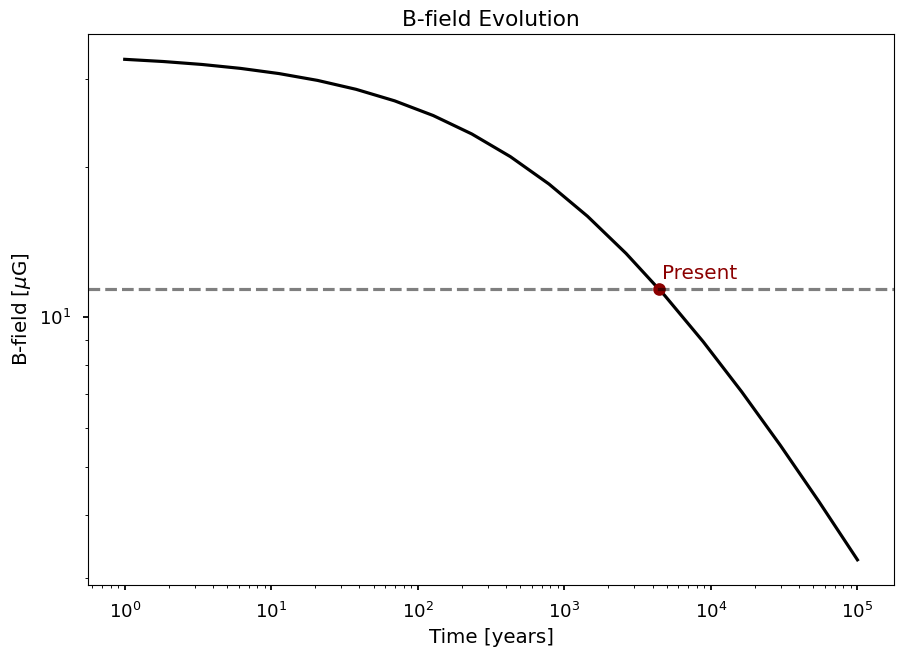

In [71]:
t = np.logspace(0, 5 ,20) # array of times from 1 to 100k yrs 
f, ax = plt.subplots()
ax.semilogx(t,pwn_fit.bfield(t)/1e-6,c='black')
ax.plot(pwn_fit.calculate_true_age(),pwn_fit.b_now/1e-6,'-o', color='darkred')
ax.text(1.05*pwn_fit.calculate_true_age(),1.05*pwn_fit.b_now/1e-6,'Present',fontsize='x-large',color='darkred')
ax.axhline(y=pwn_fit.b_now/1e-6, color='black', linestyle='--', alpha=0.5)
plt.xlabel("Time [years]")
plt.ylabel("B-field [$\mu$G]")
plt.title("B-field Evolution")
plt.loglog()
fig = plt.gcf()
save(fig, 'time_evolution_bfield_6kpc_new')

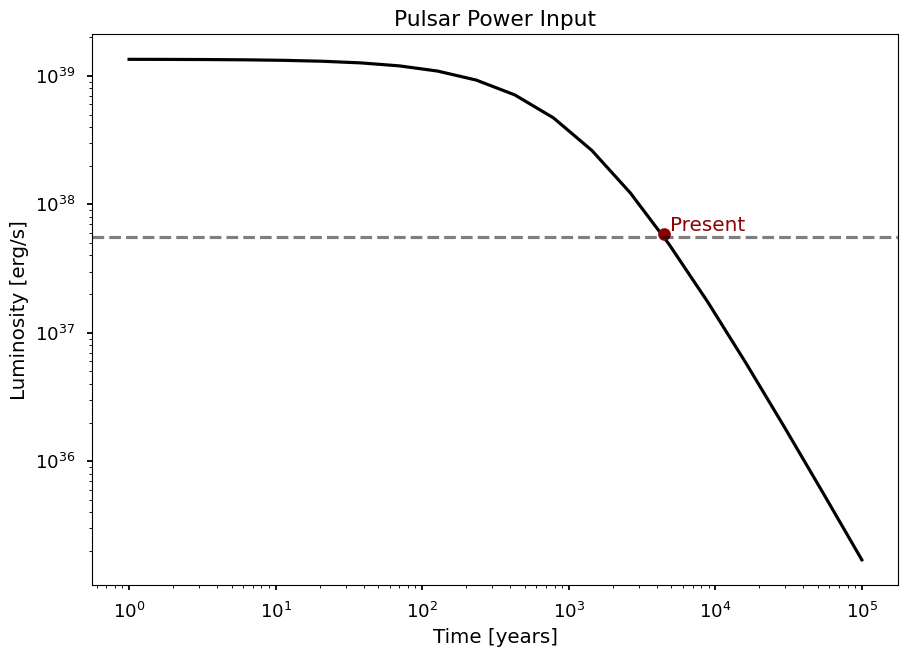

In [72]:
f, ax = plt.subplots()
ax.semilogx(t,pwn_fit.luminosity(t)/pwn_fit.theta,c='black')
ax.plot(pwn_fit.calculate_true_age(),1.05*pwn_fit.e_dot,'-o', color='darkred')
ax.text(1.1*pwn_fit.calculate_true_age(),1.1*pwn_fit.e_dot,'Present',fontsize='x-large',color='darkred')
ax.axhline(y=pwn_fit.e_dot, color='black', linestyle='--', alpha=0.5)
plt.xlabel("Time [years]")
plt.ylabel("Luminosity [erg/s]")
plt.title("Pulsar Power Input")
plt.loglog()
fig = plt.gcf()
save(fig, 'time_evolution_luminosity_6kpc_new')

Particles::SetMembers: Time (1627.27yrs vs {1,1627.09}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 


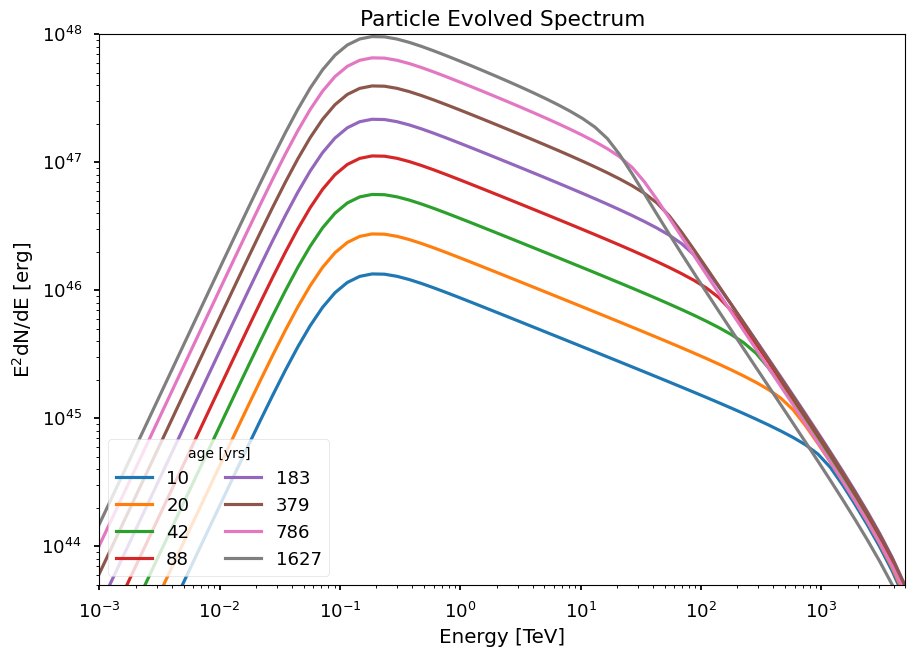

In [73]:
#evolved particle spectrum plot
ppe = []
t = np.logspace(1,np.log10(relic_age*1000),8)
for tt in t:
        fp_pwn.SetAge(tt)
        fp_pwn.CalculateElectronSpectrum()
        ppe.append(np.array(fp_pwn.GetParticleSED()))

f, ax = plt.subplots()
for pe,tt in zip(ppe,t):
    ax.loglog(pe[:,0],pe[:,1],label=str(int(tt)))
plt.xlabel("Energy [TeV]")
plt.ylabel("E"+r"$^2$"+"dN/dE [erg]")
plt.legend(title="age [yrs]",ncol=2,loc="lower left")
plt.ylim(ymin=5*1e43,ymax=1e48)
plt.xlim(xmin=1e-3,xmax=5e3)
plt.title("Particle Evolved Spectrum")
fig = plt.gcf()
save(fig, 'evolved_particle_spectrum_6kpc_new')

In [74]:
t = np.logspace(0, 5 ,20000) # array of times from 1 to 100k yrs                                                                                                                                                                       
e_photon = np.logspace(-6,15,bins) * gp.eV_to_erg # defines energies at which gamma-ray emission should be calculated 
e_electron = np.logspace(np.log10(gp.m_e/gp.TeV_to_erg),4,bins) * gp.TeV_to_erg #defines the injected electron energy range
e_electron_snr = np.logspace(np.log10(gp.m_e/gp.TeV_to_erg),1,bins) * gp.TeV_to_erg
e_proton_snr = np.logspace(-5,4,bins) * gp.TeV_to_erg

In [75]:
# f, ax = plt.subplots()
# power_protons = np.power(10,snr_fit.power_p)
# proton_inj_spec = np.array(snr_fit.injection_spectrum(e_proton_snr,snr_fit.alpha_p,gp.m_p/gp.TeV_to_erg,
#                                                          np.power(10,5),power_protons,1)) #high cut off set to very high value therefore not used
# alpha_e = snr_fit.alpha_p + snr_fit.del_alpha
# power_electrons =  power_protons #*np.power(10,hybrid_fit.k_ep)
# electron_inj_spec = np.array(snr_fit.injection_spectrum(e_electron_snr,alpha_e,gp.m_e/gp.TeV_to_erg,
#                                                            1,power_electrons,2))

# ax.plot(proton_inj_spec[:,0]/gp.TeV_to_erg,np.power(proton_inj_spec[:,0],2)*proton_inj_spec[:,1]/1e51, color='green', label="Protons")
# ax.plot(electron_inj_spec[:,0]/gp.TeV_to_erg,np.power(electron_inj_spec[:,0],2)*electron_inj_spec[:,1]/1e51, color='black', label="Electrons/K$_{ep}$")
# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.set_xlim(1e-6,4e3)
# ax.set_ylim(1e-6,1e-1)
# ax.legend()
# plt.xlabel("Energy [TeV]")
# plt.ylabel("E"+r"$^2$"+"dN/dE [10$^{51}$erg]")
# save(fig, 'snr_inj_spec')

#### electron spectrum from gamma-ray observation

In [76]:
t = np.logspace(0, 5 ,20000) # array of times from 1 to 100k yrs
e_electron = np.logspace(np.log10(gp.m_e/gp.TeV_to_erg),4,400) * gp.TeV_to_erg 
bins = 200
e_photon = np.logspace(-2,2.5,bins) * gp.TeV_to_erg 

In [77]:
gamma_sed, fp, fr = pwn_fit.model_pwn(t, e_electron, e_photon, 1-pwn_fit.time_frac_pwn, False)

Particles::SetMembers: Time (1750.12yrs vs {1,1749.49}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 
Particles::SetMembers: Time (1749.77yrs vs {1,1749.49}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 


In [78]:
import os
if os.path.isfile(f'../data_points/electron_spectrum_full_400bins_new.npy'):
    with open('/lfs/l7/hess/users/twach/modeling/Modeling/data_points/electron_spectrum_full_400bins_new.npy', 'rb') as f:
        electron_spectrum_full = np.load(f)
else:
    fp.CalculateElectronSpectrum(bins=400)
    electron_spectrum_full = np.array(fp.GetParticleSpectrum())
    with open('/lfs/l7/hess/users/twach/modeling/Modeling/data_points/electron_spectrum_full_400bins_new.npy', 'wb') as f:
        np.save(f, electron_spectrum_full)

Particles::SetMembers: Time (1749.57yrs vs {1,1749.49}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 
Particles::SetMembers: Time (1749.73yrs vs {1,1749.49}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 
Particles::SetMembers: Time (1749.89yrs vs {1,1749.49}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 
Particles::SetMembers: Time (1750.05yrs vs {1,1749.49}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g.

In [79]:
from scipy.interpolate import splev, splrep
#Get the spline interpolated gamma sed
# find better curvature for data
spl_g_sed = splrep(gamma_sed[:,0], gamma_sed[:,1])

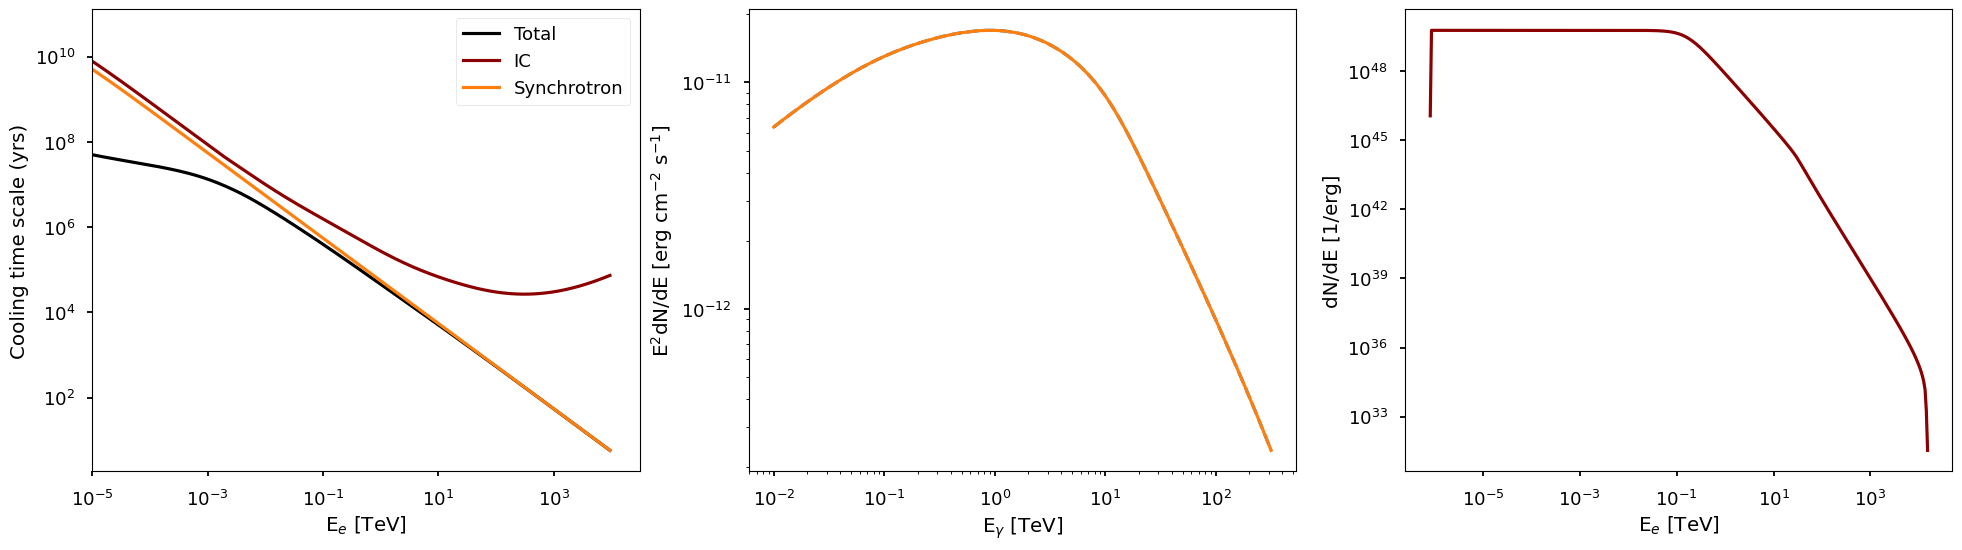

In [80]:
f, ax = plt.subplots(1,3, figsize=(24,6))
#cooling timesclaes
total = np.array(fp.GetCoolingTimeScale(electron_spectrum_full[:,0],"sum"))
ic = np.array(fp.GetCoolingTimeScale(electron_spectrum_full[:,0],"inverse_compton"))
sync = np.array(fp.GetCoolingTimeScale(electron_spectrum_full[:,0],"synchrotron"))

ax[0].loglog(total[:,0]/gp.TeV_to_erg,total[:,1],c="black",ls="-",label="Total", )
ax[0].loglog(ic[:,0]/gp.TeV_to_erg,ic[:,1],c="darkred",ls="-",label="IC")
ax[0].loglog(sync[:,0]/gp.TeV_to_erg,sync[:,1],c="tab:orange",ls="-",label="Synchrotron")
ax[0].set_xlabel("E$_{e}$ [TeV]")
ax[0].set_ylabel("Cooling time scale (yrs)")
ax[0].legend()
ax[0].set_xlim(1e-5)
ax[1].loglog(gamma_sed[:,0],gamma_sed[:,1],linestyle="--")
ax[1].loglog(gamma_sed[:,0],splev(gamma_sed[:,0],spl_g_sed),linestyle="-")
ax[1].set_xlabel('E$_{\gamma}$ [TeV]')
ax[1].set_ylabel("E"+r"$^2$"+"dN/dE [erg cm"+r"$^{-2}$"+" s"+r"$^{-1}$""]")
ax[2].loglog(electron_spectrum_full[:,0],electron_spectrum_full[:,1],linestyle="-", color='darkred')
ax[2].set_ylabel("dN/dE [1/erg]")
ax[2].set_xlabel('E$_{e}$ [TeV]')
f.savefig("/lfs/l7/hess/users/twach/modeling/Modeling/cooling_timescales_new.png",bbox_inches='tight')
f.savefig("/lfs/l7/hess/users/twach/modeling/Modeling/cooling_timescales_new.pdf",bbox_inches='tight')

In [81]:
import os
if os.path.isfile(f'../data_points/electron_spectrum_full_400bins_1GeV_new.npy'):
    with open('/lfs/l7/hess/users/twach/modeling/Modeling/data_points/electron_spectrum_full_400bins_new.npy', 'rb') as f:
        electron_spectrum_full = np.load(f)
else:
    fp.CalculateElectronSpectrum(bins=400)
    electron_spectrum_full = np.array(fp.GetParticleSpectrum())
    with open('/lfs/l7/hess/users/twach/modeling/Modeling/data_points/electron_spectrum_full_400bins_new.npy', 'wb') as f:
        np.save(f, electron_spectrum_full)

Particles::SetMembers: Time (1749.57yrs vs {1,1749.49}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 
Particles::SetMembers: Time (1749.73yrs vs {1,1749.49}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 
Particles::SetMembers: Time (1749.89yrs vs {1,1749.49}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 
Particles::SetMembers: Time (1750.05yrs vs {1,1749.49}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g.

In [82]:
%%time
bin_size = 2
E_e = list()
E_g = list()
E_e_g = list()
electron_spectrum_full = electron_spectrum_full[0:390]
for i in range(electron_spectrum_full.shape[0]-(bin_size-1)):
    electron_spectrum = electron_spectrum_full[i:i+bin_size,:]
    e_electron = electron_spectrum[:,0] * gp.TeV_to_erg #defines the injected electron energy range
    fr.SetElectrons(electron_spectrum)
    fr.CalculateDifferentialPhotonSpectrum(e_photon)
    
    gamma_sed_temp = np.array(fr.GetTotalSED())
    if(gamma_sed_temp.shape[0] == 0):
        continue
    #check if interpolated gamma sed worked
    interpolated_gamma_sed = splev(gamma_sed_temp[:,0],spl_g_sed)
    if(interpolated_gamma_sed.shape[0] == 0):
        continue
    ratio = gamma_sed_temp[:,1]/interpolated_gamma_sed
    avg_electron_energy = np.power(10,np.log10(e_electron).sum()/bin_size)
    E_e.append(np.ones(gamma_sed_temp.shape[0])*avg_electron_energy)
    E_g.append(gamma_sed_temp[:,0])
    E_e_g.append(ratio)

CPU times: user 1min 7s, sys: 18.7 ms, total: 1min 7s
Wall time: 1min 8s


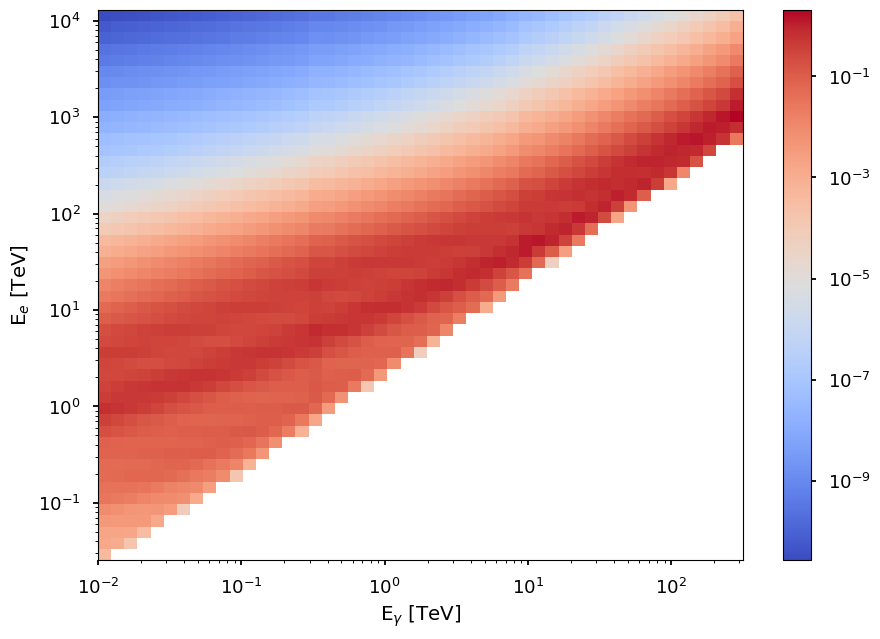

In [83]:
#to which gamma-ray energies does an electron with energy x contribute
x = np.concatenate(E_g).ravel()
y = np.concatenate(E_e).ravel()#*np.concatenate(E_e_g).ravel()
w = np.concatenate(E_e_g).ravel()
bins_x = np.logspace(np.log10(x.min()),np.log10(x.max()), 50)
bins_y = np.logspace(np.log10(y.min()),np.log10(y.max()), 50)
zi, yi, xi = np.histogram2d(y, x, weights=w, bins=[bins_y,bins_x])
fig, ax = plt.subplots()
im = ax.pcolormesh(xi, yi, zi, cmap='coolwarm', norm=colors.LogNorm())
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('E$_{\gamma}$ [TeV]')
ax.set_ylabel('E$_{e}$ [TeV]')
fig.colorbar(im);
save(fig, 'electron_gamma_energy_template_new')
#f.savefig("/home/woody/caph/mppi103h/PSR_J1813-1749/Modeling/electron_gamma_energy_template.png",bbox_inches='tight')
#f.savefig("/home/woody/caph/mppi103h/PSR_J1813-1749/Modeling/electron_gamma_energy_template.pdf",bbox_inches='tight')

#### Fitting the diffusion index and coefficient

In [84]:
def get_electron_energy_contribution(gamma_bin):
    e_binc = np.power(10,(np.log10(yi[1:])+np.log10(yi[:-1]))/2.)
    g_to_e_bin_dist = zi[:,gamma_bin]
    mask_zeros = g_to_e_bin_dist > 0
    electron_energies = e_binc[mask_zeros]
    contributions = g_to_e_bin_dist[mask_zeros]
    return electron_energies * u.TeV, contributions

In [85]:
def get_sizes(D0, D_index, age, E_e):
    D0 = D0 * u.cm**2 / u.s
    D_eref = 1 * u.TeV
    D = D0 * np.power(E_e / D_eref, D_index).decompose()
    t_cool = np.array(fp.GetCoolingTimeScale(E_e.value,"sum"))[:,1] * u.yr
    r_cool = (np.sqrt(2.0*t_cool*D)).to('pc')
    r_age = (np.sqrt(2.0*age*D)).to('pc')
    r_min = np.minimum(r_cool, r_age)
    r_min_deg = r_min / (pwn_fit.distance * u.pc) * 180 * u.deg / np.pi
    return r_min, r_min_deg, r_cool, r_age, r_min

In [86]:
def get_final_size(D0, D_index, age_fit):
    g_binc = np.power(10,(np.log10(xi[1:])+np.log10(xi[:-1]))/2.)
    final_size = list()
    for gamma_bin,gamma_energy in enumerate(g_binc):
        electron_energies_temp, contributions_temp = get_electron_energy_contribution(gamma_bin)
        r_min, r_min_deg, r_cool, r_age, r_min = get_sizes(D0, D_index, age_fit, electron_energies_temp)
        nume = sp.integrate.simps(r_min_deg*contributions_temp,electron_energies_temp)
        deno = sp.integrate.simps(contributions_temp,electron_energies_temp)
        final_size.append(nume/deno)
    return g_binc * u.TeV, np.array(final_size) * u.deg

In [87]:
def model_for_fitting(ene, D0, D_index):
    age_fit = pwn_fit.calculate_true_age()*(1-pwn_fit.time_frac_pwn) * u.yr
    energy, size = get_final_size(D0, D_index, age_fit)
    spl = splrep(energy.value, size.value)
    return splev(ene, spl)

In [88]:
%%latex
\begin{equation*}
D  = D_0 \left( \frac{E_e}{1 \ \mathrm{TeV}} \right)^{\delta}
\end{equation*}

<IPython.core.display.Latex object>

#### Mearsured extension from HESS

In [89]:
import scipy.optimize as opt

In [90]:
### Extent of component 1 vs energy from HESS analysis ###
p1 = [1e28, 0.9]
#only HESS data:
#sigma_hess_comp_1_ebands_x = [0.7, 2, 51.5]
#sigma_hess_comp_1_ebands_y = [0.89, 0.58, 0.41]
#sigma_hess_comp_1_ebands_yerr= [0.13, 0.03, 0.01]
# HESS and Fermi data:
energy_size = [(0.001 + 0.0018)/2, (0.0018  + 0.0042)/2, (0.0042 + 0.0101)/2, (0.0101 + 0.0238)/2, (0.0238 + 0.0563)/2, (0.0563 + 1)/2, (0.4 + 1.34)/2, (1.34  + 5.7)/2, (5.7 + 100)/2]
sigma = [0.457, 0.407, 0.521, 0.549, 0.499, 0.705, 0.872, 0.482, 0.411,]
sigma_err= [0.034, 0.034, 0.099, 0.130, 0.074, 0.194, 0.120, 0.092, 0.091]

res = opt.curve_fit(model_for_fitting, energy_size, sigma, p0=p1, sigma=sigma_err, absolute_sigma=True)
print(res)  

(array([1.64021665e+29, 2.98322953e-01]), array([[ 4.22821455e+56, -9.18567241e+26],
       [-9.18567241e+26,  3.90965015e-03]]))


In [110]:
p1 = [1e28]
res_0pt33 = opt.curve_fit(lambda x, a: model_for_fitting(x, a, 0.33), energy_size, sigma, p0=p1, sigma=sigma_err, absolute_sigma=True) 
res_1pt0 = opt.curve_fit(lambda x, a: model_for_fitting(x, a, 0.5), energy_size, sigma, p0=p1, sigma=sigma_err, absolute_sigma=True)
# res_0pt33 = model_for_fitting(x, res[0][0], 0.33) 
# res_1pt0 = model_for_fitting(x, res[0][0], 1.0)

In [111]:
print(res_0pt33)
print(res_1pt0)

(array([1.56486318e+29]), array([[1.88519047e+56]]))
(array([1.13949064e+29]), array([[1.02336406e+56]]))


In [112]:
res

(array([1.64021665e+29, 2.98322953e-01]),
 array([[ 4.22821455e+56, -9.18567241e+26],
        [-9.18567241e+26,  3.90965015e-03]]))

In [113]:
age_fit = pwn_fit.calculate_true_age()*(1-pwn_fit.time_frac_pwn) * u.yr
#energy_toy_model, size_toy_model = get_final_size(7e27, 0.33, 16e3*u.yr) #Lars' Toy model values
energy, size = get_final_size(res[0][0], res[0][1], age_fit)
energy1, size1 = get_final_size(res_0pt33[0][0], 0.33, age_fit)
energy2, size2 = get_final_size(res_1pt0[0][0], 0.5, age_fit)

In [114]:
res[0][0]

1.640216652781194e+29

In [117]:
res[0][1]

0.29832295332445946

In [115]:
np.sqrt(np.diag(res[1]))

array([2.05626228e+28, 6.25271953e-02])

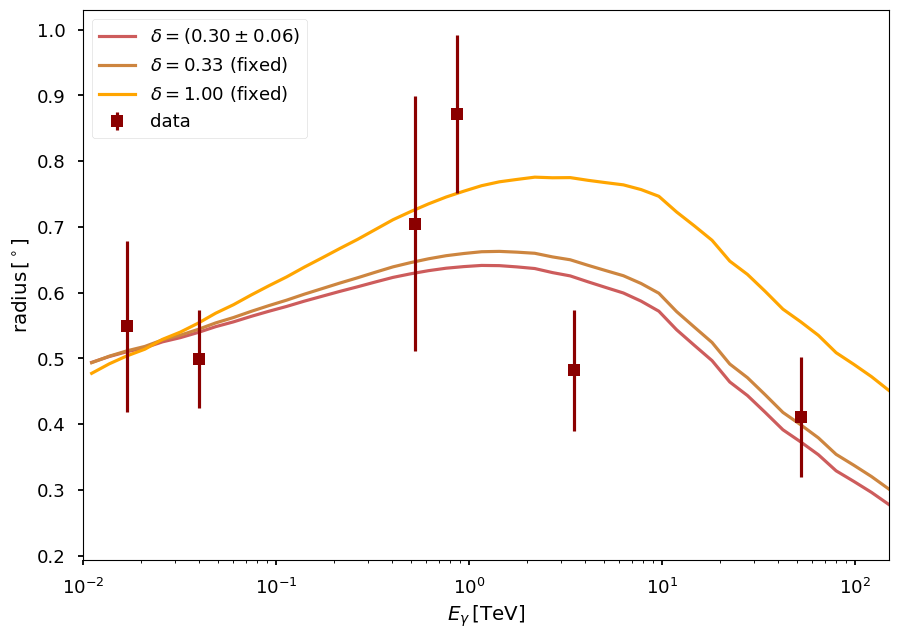

In [116]:
f, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"   

ax.set_xscale('log')
ax.set_xlabel(r'$E_\gamma\,[\mathrm{TeV}]$')
ax.set_ylabel(r'$\mathrm{radius}\,[^\circ]$')

ax.errorbar(energy_size[6:], sigma[6:], yerr=sigma_err[6:],
                             color='darkred', marker='s', linestyle='None', zorder=5, label = 'data')
ax.errorbar(energy_size[0:6], sigma[0:6], yerr=sigma_err[0:6],
                             color='darkred', marker='s', linestyle='None', zorder=5)
ax.plot(energy, size, linestyle='-', color='indianred', label=r'$\delta = (0.30 \pm 0.06)$')
ax.plot(energy1, size1, linestyle='-', color='peru', label=r'$\delta = 0.33 \,\,\mathrm{(fixed)}$')
ax.plot(energy2, size2, linestyle='-', color='orange', label=r'$\delta = 0.5 \,\,\mathrm{(fixed)}$')
#ax.text(0.2, 0.25, r'$\mathrm{D}_0 = (1.54 \pm 0.19) \cdot 10^{29}\,\mathrm{cm}^{2}/\mathrm{s}$', color="black", fontsize=13)
ax.legend(loc=2)
ax.set_xlim(0.01, 150)

fig = plt.gcf()
save(fig, 'diffusion_coefficient_fit_new_chandra')

In [134]:
# e_binc = np.power(10,(np.log10(yi[1:])+np.log10(yi[:-1]))/2.)*u.TeV
# r_min, r_min_deg, r_cool, r_age, r_min = get_sizes(res[0][0], res[0][1], age_fit, e_binc)
# r_min_0pt33, r_min_deg_0pt33, r_cool_0pt33, r_age_0pt33, r_min_0pt33 = get_sizes(res_0pt33[0][0], 0.33, age_fit, e_binc)
# r_min_1pt0, r_min_deg_1pt0, r_cool_1pt0, r_age_1pt0, r_min_1pt0 = get_sizes(res_1pt0[0][0], 1.0, age_fit, e_binc)
# r_min_toyModel, r_min_deg_toyModel, r_cool_toyModel, r_age_toyModel, r_min_toyModel = get_sizes(7e27, 0.33, 16e3*u.yr, e_binc) #what Lars was using

In [135]:
# # Panel 2: radius in pc vs electron energy
# f, ax = plt.subplots()
# ax.loglog()
# ax.set_xlabel(r'$E_\mathrm{e}\,[\mathrm{TeV}]$')
# ax.set_ylabel(r'$r\,[\mathrm{pc}]$')

# ax.plot(e_binc.to_value('TeV'), r_cool.to_value('pc'), color='tab:green', ls='-', label='Cooling')
# ax.plot(e_binc.to_value('TeV'), r_age.to_value('pc'), color='black', ls='-', label='Age')
# #ax.plot(e_binc.to_value('TeV'), r_min.to_value('pc'), color='tab:orange', lw=2, ls='-', label='Combined')

# ax.plot(e_binc.to_value('TeV'), r_cool.to_value('pc'), color='tab:green', ls='-')
# ax.plot(e_binc.to_value('TeV'), r_age.to_value('pc'), color='black', ls='-')
# ax.plot(e_binc.to_value('TeV'), r_min.to_value('pc'), color='tab:orange', lw=2, ls='-', 
#         label=f'D0 = {res[0][0]:.2e} cm$^{2}$/s, $\delta$ = {res[0][1]:.2f}, age = {age_fit.value/1e3:.1f} kyr')

# ax.plot(e_binc.to_value('TeV'), r_cool_0pt33.to_value('pc'),color='tab:green', ls='--')
# ax.plot(e_binc.to_value('TeV'), r_age_0pt33.to_value('pc'),color='black', ls='--')
# ax.plot(e_binc.to_value('TeV'), r_min_0pt33.to_value('pc'),color='tab:red', ls='-',  lw=2, 
#         label=f'D0 = {res_0pt33[0][0]:.2e} cm$^{2}$/s, $\delta$ = {0.33}, age = {age_fit.value/1e3:.1f} kyr')

# ax.plot(e_binc.to_value('TeV'), r_cool_1pt0.to_value('pc'), color='tab:green', ls='-.')
# ax.plot(e_binc.to_value('TeV'), r_age_1pt0.to_value('pc'), color='black', ls='-.')
# ax.plot(e_binc.to_value('TeV'), r_min_1pt0.to_value('pc'), color='tab:purple', ls='-', lw=2, 
#         label=f'D0 = {res_1pt0[0][0]:.2e} cm$^{2}$/s, $\delta$ = {1}, age = {age_fit.value/1e3:.1f} kyr')


# ax.legend()
# ax.set_ylim(13, 200)
# ax.set_xlim(0.1,1e3)
# save(fig, 'size_vs_electron_energy')

#### Energy density estimates

In [118]:
def calculate_energy_density(e_dot, char_age, distance, ang_size, eccentricity=0):
    #conversions
    yr_to_sec = 3.154e7
    pc_to_cm = 3.086e18
    erg_to_eV = 6.242e11
    proj_size = np.deg2rad(ang_size) * distance 
    semi_minor_axis = ang_size * np.sqrt(1-eccentricity**2)
    proj_size_minor = np.deg2rad(semi_minor_axis) * distance 
    
    total_E = e_dot * char_age * yr_to_sec
    #volume = 4/3 * np.pi * np.power(proj_size * pc_to_cm,3)
    volume = 4/3 * np.pi * np.power(proj_size_minor * pc_to_cm,2) * (proj_size * pc_to_cm)
    #volume under a 2D gaussian curve: V = 2pi A* sigma_x * sigma_y with A the normalization
    #volume = 2*np.pi * proj_size * pc_to_cm *np.power(proj_size_minor * pc_to_cm,2)
    edens = total_E/volume * erg_to_eV
    return edens

In [119]:
ang_size_comp1 = 0.543 #deg #semi-major axis
ang_size_comp2 = 0.0562 #deg
eccentricity = 0.731

distance = 6.2e3 #pc
e_dot = 5.6e37
char_age = 5585
true_age = 4100
edens_comp1 = calculate_energy_density(e_dot, char_age, distance, ang_size_comp1, eccentricity)
edens_comp2 = calculate_energy_density(e_dot, char_age, distance, ang_size_comp2)
print('extended component:',"{:.2e}".format(edens_comp1), ', compact component:', "{:.2e}".format(edens_comp2))

edens_comp1 = calculate_energy_density(e_dot, true_age, distance, ang_size_comp1, eccentricity)
edens_comp2 = calculate_energy_density(e_dot, true_age, distance, ang_size_comp2)
print('extended component:',"{:.2e}".format(edens_comp1),', compact component:', "{:.2e}".format(edens_comp2), ', true age')

extended component: 5.29e-01 , compact component: 2.22e+02
extended component: 3.89e-01 , compact component: 1.63e+02 , true age


In [120]:
print('In log10 scale:')
print('extended component:', np.log10(2.39e-01), ', compact component:',np.log10(1.38e+02))
print('extended component:', np.log10(2.73e-01), ', compact component:',np.log10(1.59e+02))

In log10 scale:
extended component: -0.6216020990518624 , compact component: 2.1398790864012365
extended component: -0.563837352959244 , compact component: 2.2013971243204513


#### calculate energy density from TeV luminosity:

In [121]:
fp_pwn.GetParticleEnergyContent()

3.61822891752613e+48

In [122]:
def calculate_energy_density(total_E, distance, ang_size, eccentricity=0):
    #conversions
    yr_to_sec = 3.154e7
    pc_to_cm = 3.086e18
    erg_to_eV = 6.242e11
    proj_size = np.deg2rad(ang_size) * distance 
    semi_minor_axis = ang_size * np.sqrt(1-eccentricity**2)
    proj_size_minor = np.deg2rad(semi_minor_axis) * distance 
    
    #total_E = e_dot * char_age * yr_to_sec
    #volume = 4/3 * np.pi * np.power(proj_size * pc_to_cm,3)
    volume = 4/3 * np.pi * np.power(proj_size_minor * pc_to_cm,2) * (proj_size * pc_to_cm)
    #volume under a 2D gaussian curve: V = 2pi A* sigma_x * sigma_y with A the normalization
    #volume = 2*np.pi * proj_size * pc_to_cm *np.power(proj_size_minor * pc_to_cm,2)
    edens = total_E/volume * erg_to_eV
    return edens

In [123]:
ang_size_comp1 = 0.62 #deg #semi-major axis
ang_size_comp2 = 0.0953 #deg
eccentricity = 0.82

distance = 3.3e3 #pc
total_E = 1.19*10**51
print('total energy in particles (electrons):', total_E)
edens_comp1 = calculate_energy_density(total_E, distance, ang_size_comp1, eccentricity)
print(edens_comp1)

total energy in particles (electrons): 1.19e+51
404.4841119131317


In [124]:
ang_size_comp1 = 0.543 #deg #semi-major axis
ang_size_comp2 = 0.0562 #deg
eccentricity = 0.731

distance = 6.2e3 #pc
total_E = fp_pwn.GetParticleEnergyContent()
print('total energy in particles (electrons):', total_E)
edens_comp1 = calculate_energy_density(total_E, distance, ang_size_comp1, eccentricity)
edens_comp2 = calculate_energy_density(total_E, distance, ang_size_comp2)
print('extended component:',"{:.2e}".format(edens_comp1), ', compact component:', "{:.2e}".format(edens_comp2))

print('In log10 scale:')
print('extended component:', np.log10(edens_comp1), ', compact component:',np.log10(edens_comp2))

total energy in particles (electrons): 3.61822891752613e+48
extended component: 1.94e-01 , compact component: 8.16e+01
In log10 scale:
extended component: -0.7117125777995221 , compact component: 1.9115273121376377


### surface brightness of the x-ray emission:

In [142]:
extension_xray = 0.006
extension_pwn = 0.0562
extension_halo = 0.543

In [143]:
def calculate_surface_brightness(int_flux, extension, distance_from_source=0):
    S = int_flux * (1/(2*np.pi*extension**2)*np.exp(-distance_from_source**2/(2*extension**2)))
    return S
    
def integrated_flux(energy_range_array, model_sed_array):
    flux = []
    lower_lim = energy_range_array.iloc[0] - 0.1*energy_range_array.iloc[0]
    upper_lim = energy_range_array.iloc[-1] + 0.1*energy_range_array.iloc[-1]
    data = np.where(np.logical_and(model_sed_array>= lower_lim, model_sed_array<= upper_lim))
    for i in data:
        flux.append(model_sed_array[i, 1])
    integrated = np.trapz(flux)
    return integrated

In [144]:
flux_xray = integrated_flux(df_suzaku['e_ref'], pwn_sed_xray)[0]
flux_halo = integrated_flux(df_suzaku['e_ref'], pwn_sed_relic)[0]

surface_brightness_xray = calculate_surface_brightness(flux_xray, extension_xray)
surface_brightness_halo = calculate_surface_brightness(flux_halo, extension_halo)

surface_brightness_ratio = surface_brightness_xray/surface_brightness_halo

print('The surface brighness of the x-ray pwn is:', surface_brightness_xray)
print('The surface brighness of the relic is:', surface_brightness_halo)
print('-----------------------------------------------------------------------------------------')
print('The surface brighness from the young electrons is', surface_brightness_ratio, 'times higher.')

The surface brighness of the x-ray pwn is: 6.623422901107883e-07
The surface brighness of the relic is: 3.7894129324636957e-10
-----------------------------------------------------------------------------------------
The surface brighness from the young electrons is 1747.875731453117 times higher.
